In [106]:
import lsst.daf.persistence as dafPersist
import re
import pickle
import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

from lsst.afw.math import afwMath
import lsst.afw.image as afwImage

from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing

import sncosmo
from copy import deepcopy

In [5]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Production/"

In [127]:

patches= []
with open(DATADIR+"/patches.txt", "rb") as patches_file:
    for line in patches_file:
            line = line.replace('\n','')
            text = re.split("=| ",line)
            patches.append(text[-1])
    

In [114]:
def get_weight(calexp):
    
    statsCtrl = afwMath.StatisticsControl()
    statsCtrl.setNumSigmaClip(3.0)
    statsCtrl.setNumIter(2)
    statsCtrl.setAndMask(afwImage.MaskU.getPlaneBitMask('NO_DATA'))
    statsCtrl.setNanSafe(True)

    
    
    maskedImage = calexp.getMaskedImage()
    statObj = afwMath.makeStatistics(maskedImage.getVariance(), maskedImage.getMask(), afwMath.MEANCLIP, statsCtrl)
    meanVar, meanVarErr = statObj.getResult(afwMath.MEANCLIP)
    weight = 1.0 / float(meanVar)
    return weight

In [92]:
def get_mean(calexp):
    mi = calexp.getMaskedImage()
    bad = ~calexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.MEAN, sctrl)
    return (stats.getValue(afwMath.MEAN))


def get_mean2(calexp):
    img = calexp.getMaskedImage().getImage().getArray()
    
    marr= deepcopy(calexp.getMaskedImage().getMask().getArray())
    m = calexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])

    #marr = np.ravel(marr)
    marr[marr!=m]=0
    
    t_sum = 0;
    count = 0
    for a,b in zip(img.ravel(), marr.ravel()):
        if b==32:
            t_sum +=a
            count+=1
        
    return t_sum/count

def get_threshold(dayDiff):
    factor = 1

    mi = dayDiff.getMaskedImage()
    bad = dayDiff.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.STDEVCLIP, sctrl)
    thres = (stats.getValue(afwMath.STDEVCLIP) * factor)
    return thres

def get_threshold2(calexp):
    img = deepcopy(calexp.getMaskedImage().getImage().getArray())
    
    
    marr= deepcopy(calexp.getMaskedImage().getMask().getArray())
    
    
    bad = calexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED'])
    
    img = img[marr&bad==0]
    
    return img.std()


def read_lc_files(obj):
    table = ascii.read(obj)
    return table

def match_with_lc(slc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        

        comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
        if DSTools.source_distance(val, comp)<1:
            #print "match"
            matches.append((lc,slc))


    #print len(matches)
    return matches


def get_total_matches(f, sigma, folder_name = "light_curves_adapted"):
    lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+f+"_"+str(float(sigma))+"sigma/*.dat")
    #lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+str(float(sigma))+"sigma/*.dat")

    print len(lienObj)

    try:
        pool = multiprocessing.Pool()
        res =  pool.map(read_lc_files, lienObj)
    finally:
        pool.close()

    s_candidates = res
    print len(s_candidates)

    try:
        pool = multiprocessing.Pool()
        match_res =  pool.map(match_with_lc, s_candidates)
    finally:
        pool.close()

    res_final = []
    for r in match_res:
        res_final +=r

    count = 0
    ids = []
    for control, match in res_final:
        if control[0]["id"] not in ids:
            count+=1
            ids.append(control[0]["id"])

    print count
    
    return res_final

In [32]:
butler = dafPersist.Butler(DATADIR+"daycoadd_reroll")
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 

490


In [33]:
butler2 = dafPersist.Butler(DATADIR+"detect_prod")
date_catalog = butler2.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 

313


In [125]:
butler = dafPersist.Butler(DATADIR+"tests_reroll")
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,14", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"13,13", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"20,17", 'date':"2004-05-09"})
print len(date_catalog) 

166
167
161
181
120


In [126]:
butlerc = dafPersist.Butler(DATADIR+"control_reroll")
date_catalog = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"15,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,14", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"13,13", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"14,15", 'date':"2004-05-09"})
print len(date_catalog) 
date_catalog = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":"20,17", 'date':"2004-05-09"})
print len(date_catalog) 

313
300
294
342
212


In [134]:
test_list = []
control_list = []

for patch in patches:
    if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':"2004-05-09"}) and butlerc.datasetExists("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':"2004-05-09"}):
        test = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':"2004-05-09"})
        control = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':"2004-05-09"})
        test_list.append(len(test))
        control_list.append(len(control))

In [267]:
epatches = []
#with open(DATADIR+'epatches.txt', 'w') as pfile:
for ep in patches:
    ep_s = ep.split(",")

    if int(ep_s[0])>6 and int(ep_s[0])<23 and int(ep_s[-1])>6 and int(ep_s[-1])<24:
        #print ep
        epatches.append(ep)
        #pfile.write("tract=0 patch="+ep+ " \n")



In [253]:
val = ("15","15")
print val[0]>5 and val[0]<24 and val[-1]>5 and val[-1]<25

False


In [93]:
butler = dafPersist.Butler(DATADIR+"tests_reroll", immediate=False)

In [94]:
vals = butler.subset("calexp",dataId={"runId":"05AL01", "filter":"r", "ccd":15})


In [95]:
print len(vals)
for s in vals:
    print s.dataId["visit"]

142
788965
788964
788962
784394
784514
780832
781475
781478
788104
788486
788484
788960
784517
787671
780835
788483
780829
788961
787674
788100
780355
787677
784261
788101
781479
788963
780353
784515
781476
784260
784257
787673
780833
780834
788485
784259
784516
781477
787676
780352
787675
784262
788099
787672
788482
780354
780830
784518
780356
788103
796723
793569
793919
797545
793168
797099
793922
792271
796219
796724
793920
795841
796216
792269
792181
797101
792272
797548
796220
792755
796722
795844
792753
792273
793572
795840
793167
797546
797103
797547
792756
792179
793570
792180
796221
796223
793571
796222
793169
796725
792757
797102
793165
795842
795843
792758
792754
797549
793918
793166
793921
792270
796218
796721
793568
796217
792182
797100
805371
803022
800717
800718
802229
805373
802230
805369
806145
801148
800719
801145
800721
806143
805370
806141
803023
805367
801144
805368
806144
803025
802227
803024
802231
800720
801146
805374
806142
805375
801147
802228
803021
805372


In [115]:
dict_vals = []
dict_weights = []
for s in vals:
    dId = {"tract":0, "filter":"r", "patch":"13,13", "visit":s.dataId["visit"]}
    if butler.datasetExists("deepCoadd_tempExp", dataId=dId):
        exp = butler.get("deepCoadd_tempExp", dataId=dId)
        dict_vals.append((get_mean2(exp)/get_threshold2(exp), s.dataId["visit"], exp ) )
        dict_weights.append((get_weight(exp), s.dataId["visit"]))

In [108]:
print len(dict_vals)
dict_vals

141


[(3.3801001078348776,
  788965,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f561d87bbc8>),
 (4.159610060484531,
  788964,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f561d87ba78>),
 (3.6809625601268041,
  788962,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d490>),
 (5.3974169984289144,
  784394,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d6c0>),
 (4.0227149009491505,
  784514,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718dab0>),
 (3.8729481392371197,
  780832,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d1b8>),
 (5.2903369214156335,
  781475,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718da40>),
 (5.0065329329722132,
  781478,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718dae8>),
 (3.8342302280326739,
  788104,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d3b0>),
 (3.84741288227834,
  788486,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718ddf8>),
 (3.816297501

In [116]:
import operator

sorted_x = sorted(dict_vals, key=operator.itemgetter(0))
sorted_w = sorted(dict_weights, key=operator.itemgetter(0))

In [117]:
sorted_x[-15:]

[(5.2903369214156335,
  781475,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718da40>),
 (5.2938652408068965,
  805372,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f5628007570>),
 (5.3031769908185238,
  805369,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f562a81d688>),
 (5.3448165596369739,
  805371,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f5628083260>),
 (5.370063664370873,
  784257,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d260>),
 (5.3974169984289144,
  784394,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d6c0>),
 (5.4026465441601275,
  805367,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f5628007bc8>),
 (5.5029861707586605,
  784259,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f563718d880>),
 (5.5555519649727625,
  805370,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f56280076c0>),
 (5.6388243445858279,
  784262,
  <lsst.afw.image.exposure.exposure.ExposureF at 0x7f562d041e68>),
 (5.7202825

In [121]:
sorted_w[-15:]

[(0.0032891386472196347, 801145),
 (0.003351745996853372, 780353),
 (0.003381059793932662, 800720),
 (0.003399700217605855, 780354),
 (0.003432199557041216, 780352),
 (0.0034397722815239493, 800719),
 (0.003449660024634786, 802229),
 (0.0034558631049065036, 802228),
 (0.0034657517827567457, 780356),
 (0.003471977783832125, 780355),
 (0.0034757663716858418, 802227),
 (0.003505028489095021, 800718),
 (0.0035084240034571534, 802231),
 (0.0035342129677300945, 802230),
 (0.0035394133614850033, 800717)]

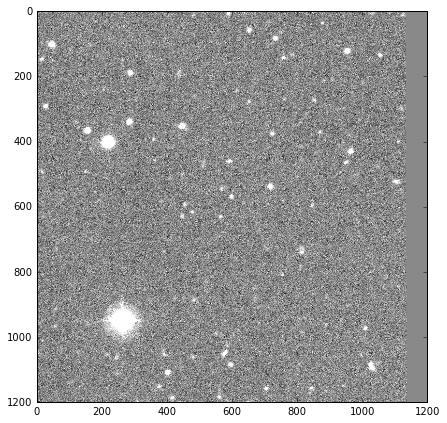

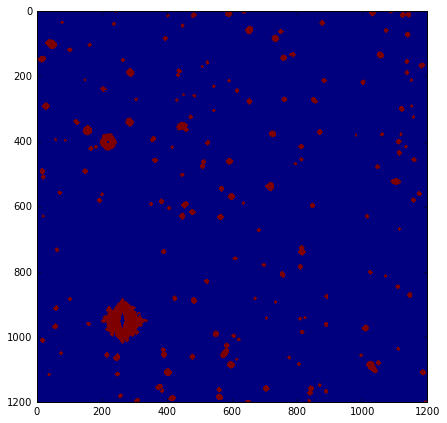

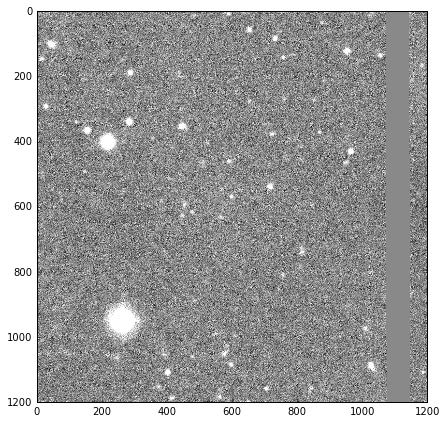

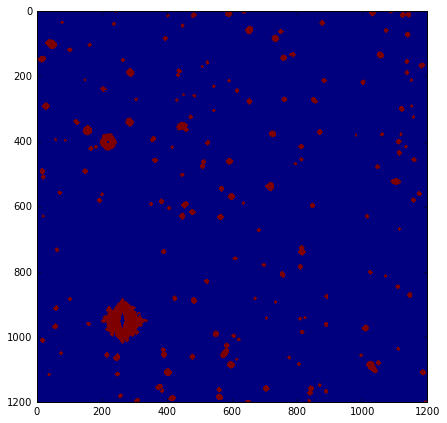

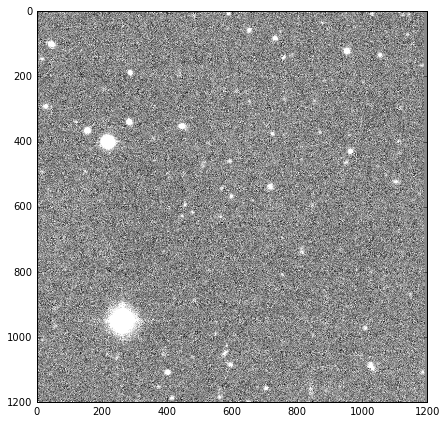

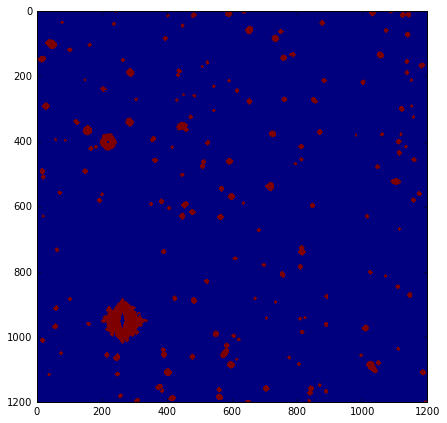

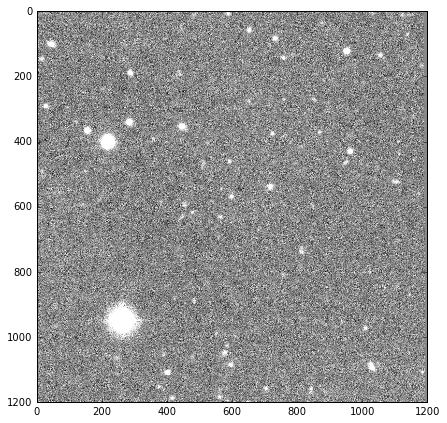

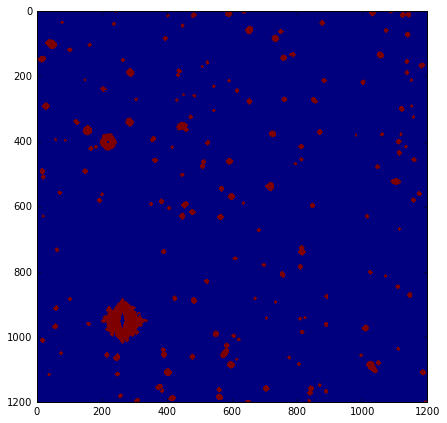

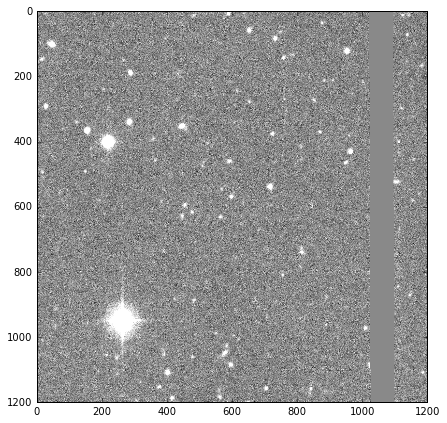

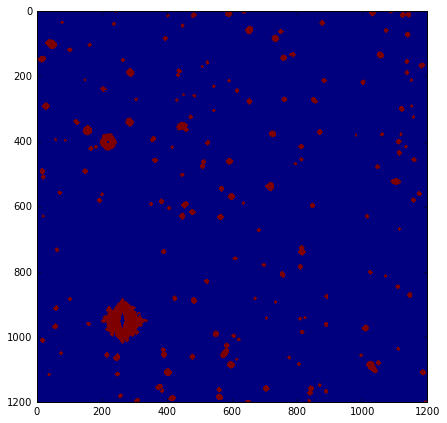

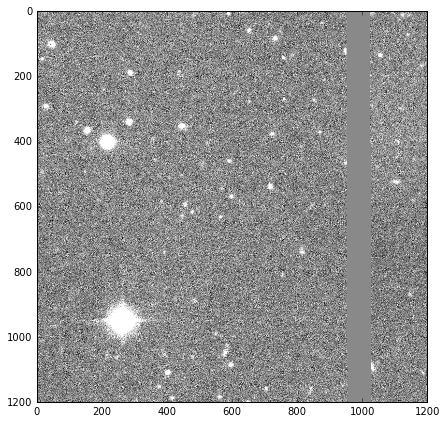

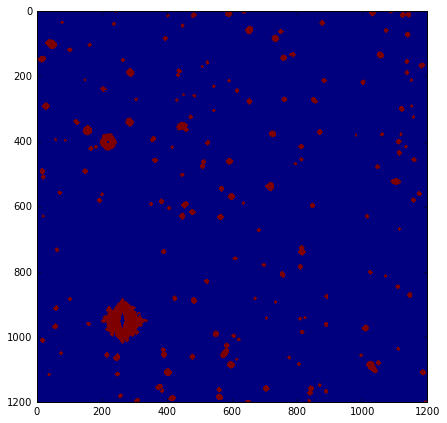

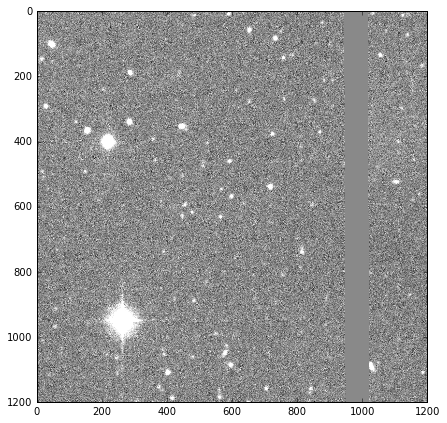

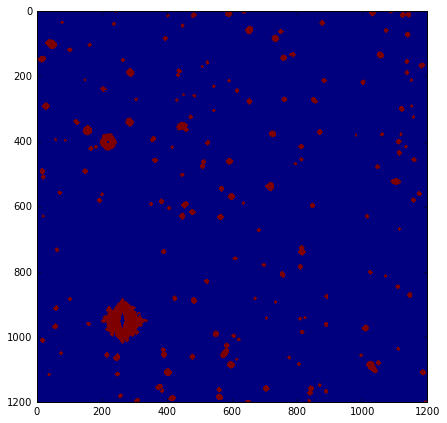

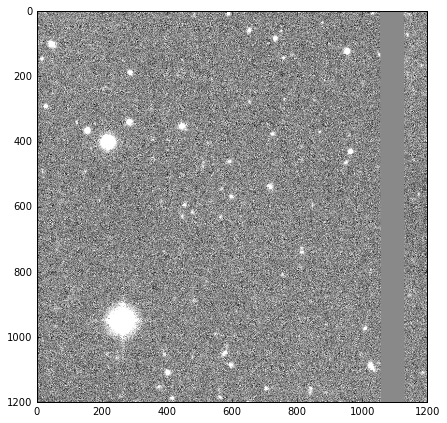

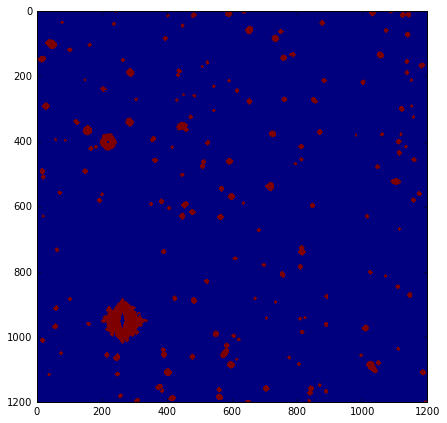

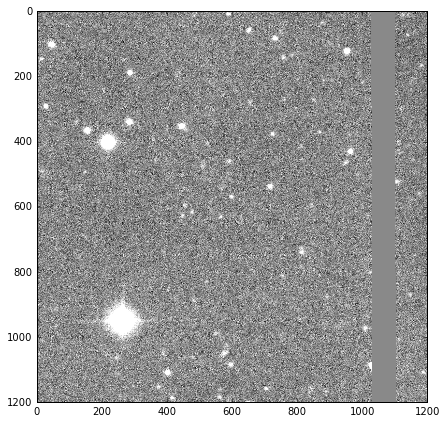

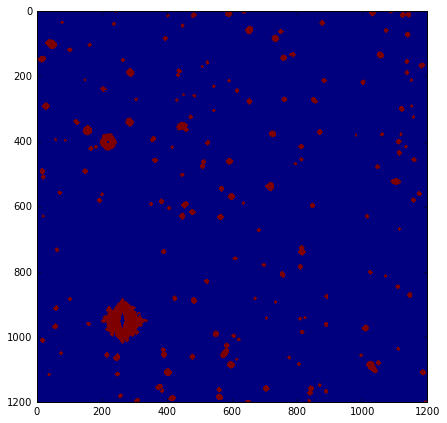

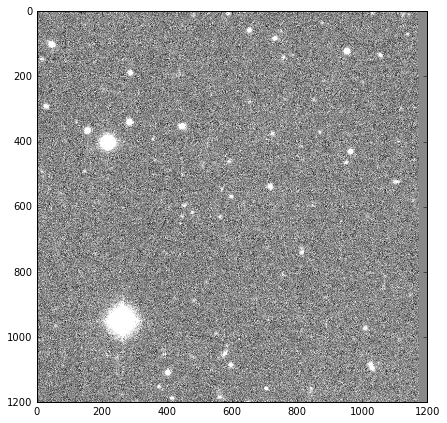

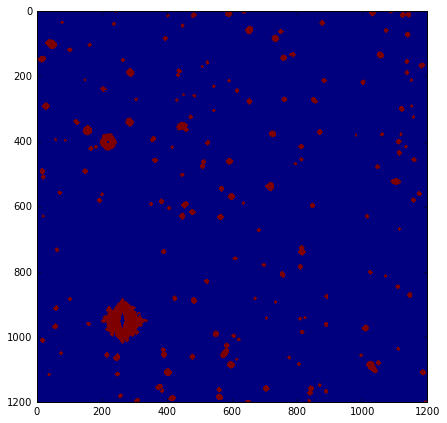

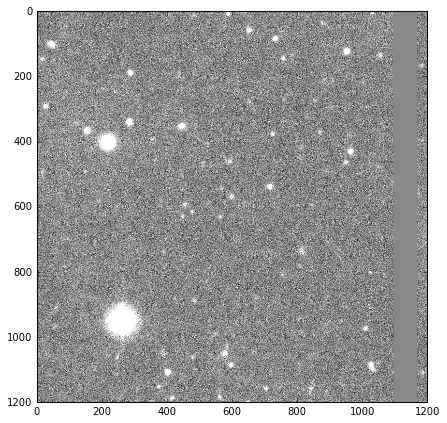

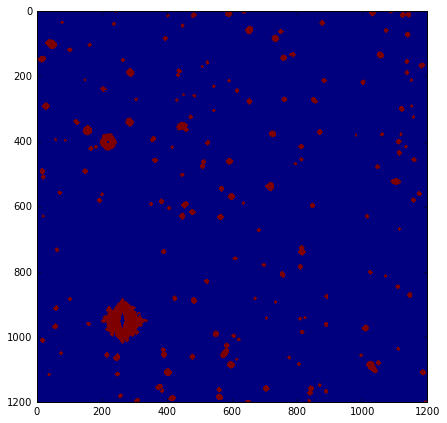

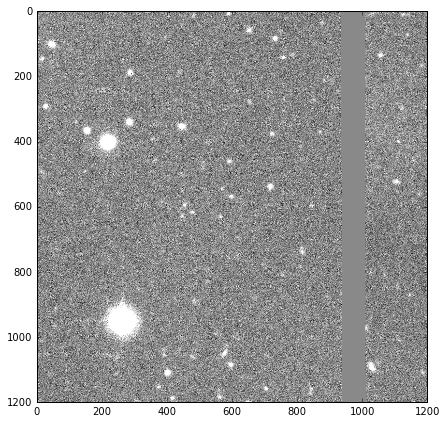

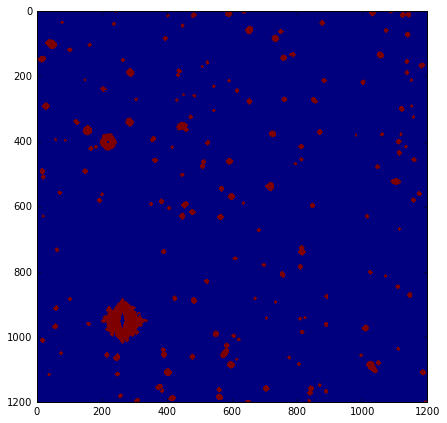

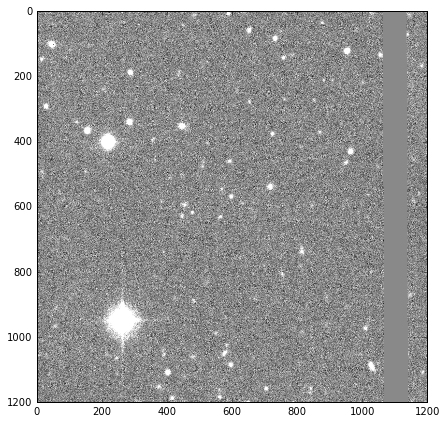

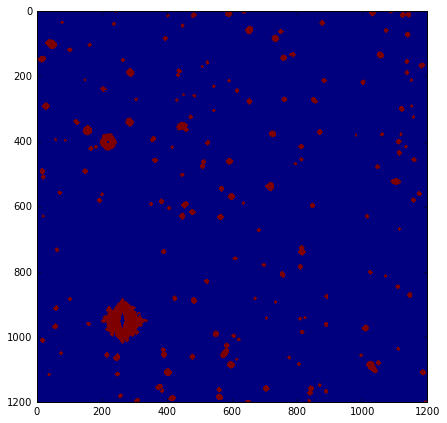

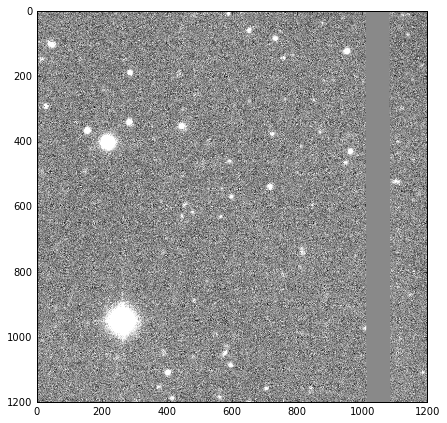

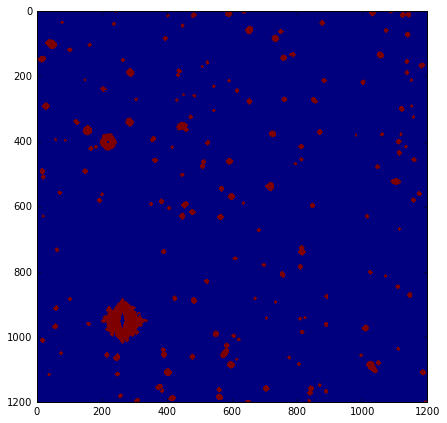

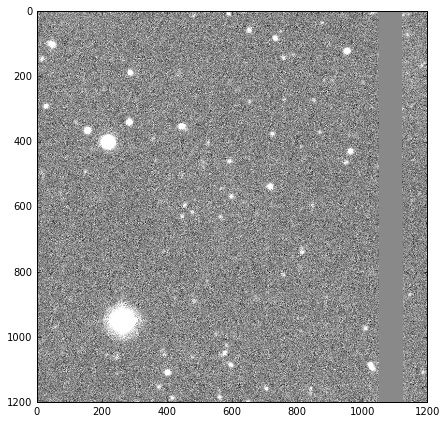

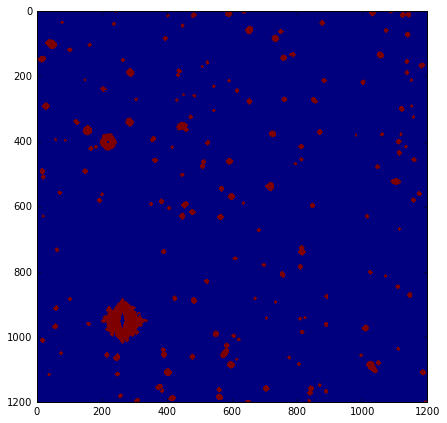

In [49]:
for sor in sorted_x[-15:]:

    warpexp = sor[-1]

    plt.figure(figsize=(7,7))
    img = warpexp.getMaskedImage().getImage().getArray()
    #img = np.flipud(img)
    plt.imshow(img, cmap="gray", vmin =-70, vmax=60)
    plt.show()
    
    
    plt.figure(figsize=(7,7))
    
    marr= deepcopy(sorted_x[11][-1].getMaskedImage().getMask().getArray())
    m = warpexp.getMaskedImage().getMask().getPlaneBitMask(['DETECTED' ])

    #marr = np.ravel(marr)
    marr[marr!=m]=0
    
    
    plt.imshow(marr)
    plt.show()

In [148]:
days = []
with open(DATADIR+"/days_04.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days.append(line)

In [151]:
missing_patches = []


for patch in patches:
        if butler.datasetExists("deepCoadd_calexp", dataId={"tract":0, "patch":patch, "filter":"r"}) == False:
            missing_patches.append(patch)

In [155]:
comp_dates = []

for day in days:
    if butler.datasetExists("dayDiff_class_diaSrc",  dataId={"filter":"r","tract":0, "patch":"15,15", 'date':day}):
        comp_dates.append(day)

In [271]:
sigma_reroll= pickle.load( open( "/datadec/cppm/jpreyes/CFHT_Production/sigma_dictionary_04_reroll.pickle", "rb" ) )
sigma_control = pickle.load( open( "/datadec/cppm/jpreyes/CFHT_Production/sigma_dictionary_04_control.pickle", "rb" ) )

In [276]:
sigma_control['15,10']

{'2004-03-17': 0.13219018887781142,
 '2004-03-19': 0.10662365796251201,
 '2004-03-30': 0.11505415279170934,
 '2004-04-14': 0.13464399037559482,
 '2004-04-22': 0.10825341594175462,
 '2004-04-26': 0.10649195537687206,
 '2004-04-28': 0.13430726945141042,
 '2004-05-09': 0.10428888063860872,
 '2004-05-13': 0.10392704078544097,
 '2004-05-21': 0.1102385327183097,
 '2004-05-24': 0.11168437574004944,
 '2004-05-26': 0.13759113687858873,
 '2004-06-09': 0.09732614350171163,
 '2004-06-13': 0.09503000599679996,
 '2004-06-19': 0.09459959516910185,
 '2004-06-22': 0.09380015385022329,
 '2004-06-26': 0.13568252546126,
 '2004-07-07': 0.13428817949160277,
 '2004-07-11': 0.10434727708751523,
 '2004-07-12': 0.1260680690430051,
 '2004-07-18': 0.10251660613738449}

In [272]:
def correct_source(srclist, patch, date, sigma_dictionary, factor=5.5):
    to_remove = []
    sigma = sigma_dictionary[patch][date]
    for i,src in enumerate(srclist):
        flux = src["base_CircularApertureFlux_4_5_flux"]
        if np.isnan(flux) or flux < sigma*factor:
            to_remove.append(i)

    

    
    return len(srclist)-len(to_remove)

In [274]:
days_comparison = {}
days_comparison_corrected = {}
goods = []
goods_corrected = []

for day in comp_dates:
    test_list = []
    control_list = []
    total = 0
    good = 0
    good_c = 0
    for patch in epatches:
        if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':day}) and butlerc.datasetExists("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':day}):
            test = butler.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':day})
            control = butlerc.get("dayDiff_class_diaSrc", dataId={"filter":"r","tract":0, "patch":patch, 'date':day})
            
            test_list.append(len(test))
            control_list.append(len(control))
            
            #CORRECTED VERSION -start
            print patch
            len_test = correct_source(test, patch, day, sigma_reroll)
            a1.append(len_test)
            len_control = correct_source(control, patch, day, sigma_control)
            b1.append(len_control)
            
            if len_test > len_control:
                good_c+=1
                
            
            
            
            #CORRECTION VERSION - end
            
            total+=1
            if len(test)>len(control):
                good+=1
            
                
            
    
    
    goods.append((good, total))
    
    goods_corrected.append((good_c, total))
            
    days_comparison[day]=(test_list, control_list)
    
    days_comparison_corrected[day]=(a1, b1)
    

7,7
7,8
7,9
7,10
7,11
7,12
7,13
7,14
7,15
7,16
7,17
7,18
7,19
7,20
7,21
7,22
7,23
8,7
8,8
8,9
8,10
8,11
8,12
8,13
8,14
8,15
8,16
8,17
8,18
8,19
8,20
8,21
8,22
8,23
9,7
9,8
9,9
9,10
9,11
9,12
9,13
9,14
9,15
9,16
9,17
9,18
9,19
9,20
9,21
9,22
9,23
10,7
10,8
10,9
10,10
10,11
10,12
10,13
10,14
10,15
10,16
10,17
10,18
10,19
10,20
10,21
10,22
10,23
11,7
11,8
11,9
11,10
11,11
11,12
11,13
11,14
11,15
11,16
11,17
11,18
11,19
11,20
11,21
11,22
11,23
12,7
12,8
12,9
12,10
12,11
12,12
12,13
12,14
12,15
12,16
12,17
12,18
12,19
12,20
12,21
12,22
12,23
13,7
13,8
13,9
13,10
13,11
13,12
13,13
13,14
13,15
13,16
13,17
13,18
13,19
13,20
13,21
13,22
13,23
14,7
14,8
14,9
14,11
14,12
14,13
14,14
14,15
14,16
14,17
14,18
14,19
14,20
14,21
14,22
14,23
15,7
15,8
15,9
15,10


KeyError: '2004-03-19'

In [ ]:
print goods_corrected

2004-03-19
0.591176470588


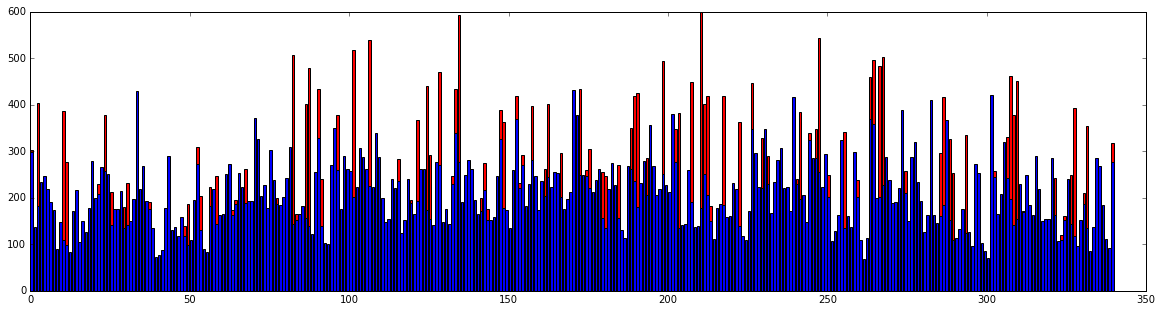

2004-04-26
0.588235294118


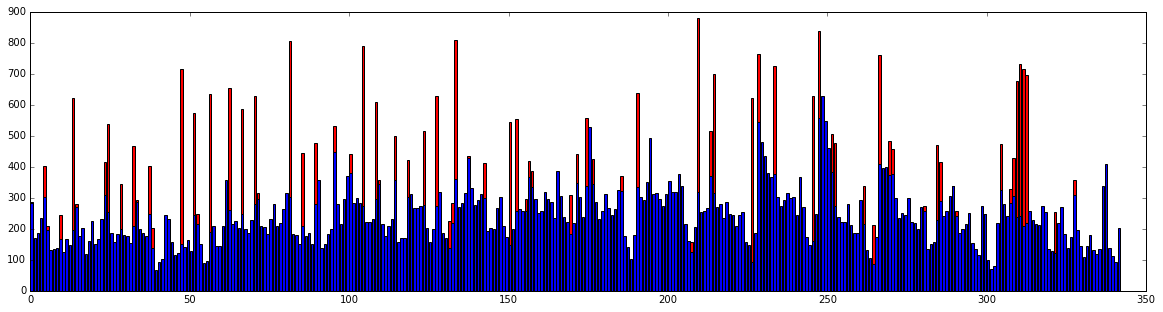

2004-05-24
0.754385964912


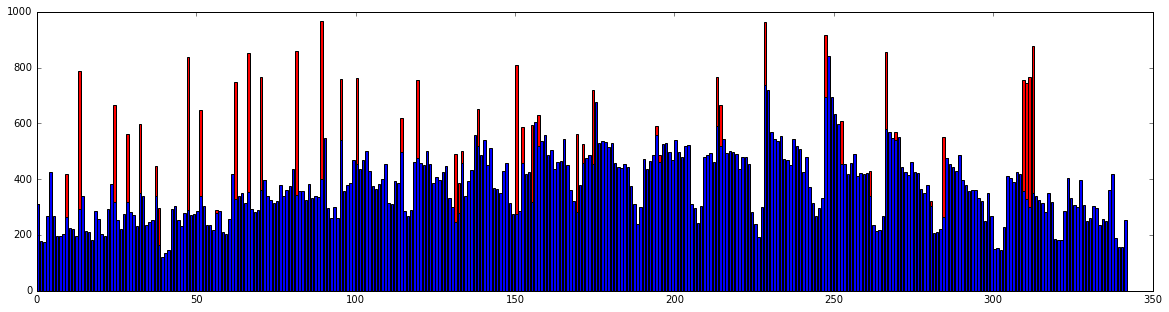

2004-05-09
0.634502923977


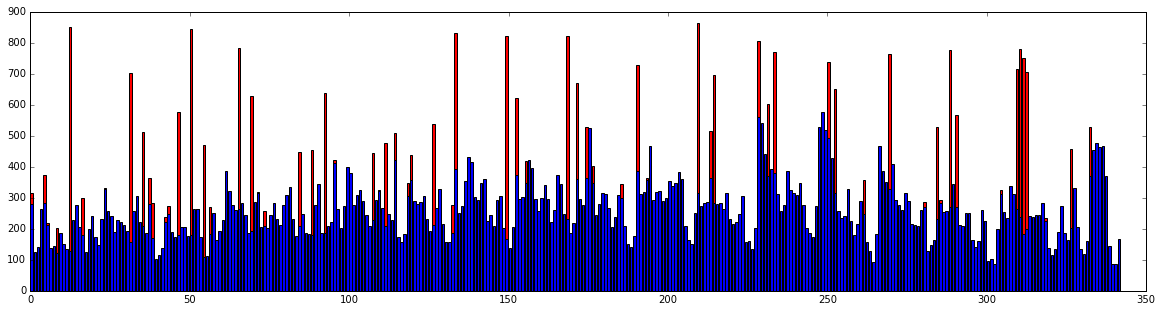

2004-04-14
0.769005847953


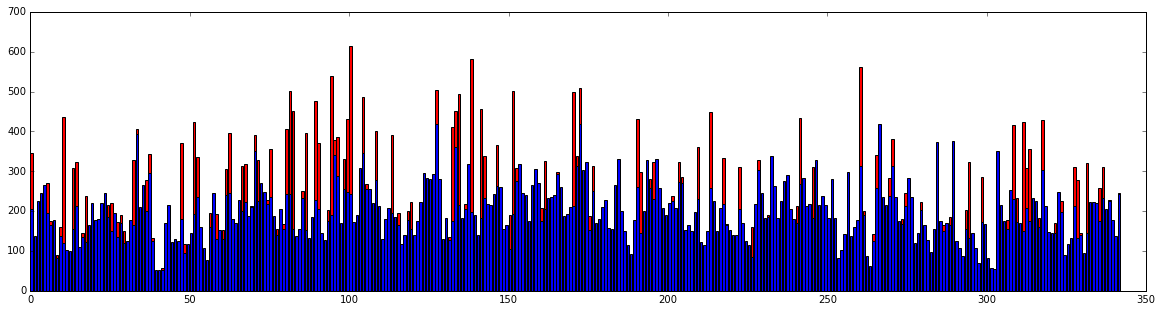

2004-05-21
0.657894736842


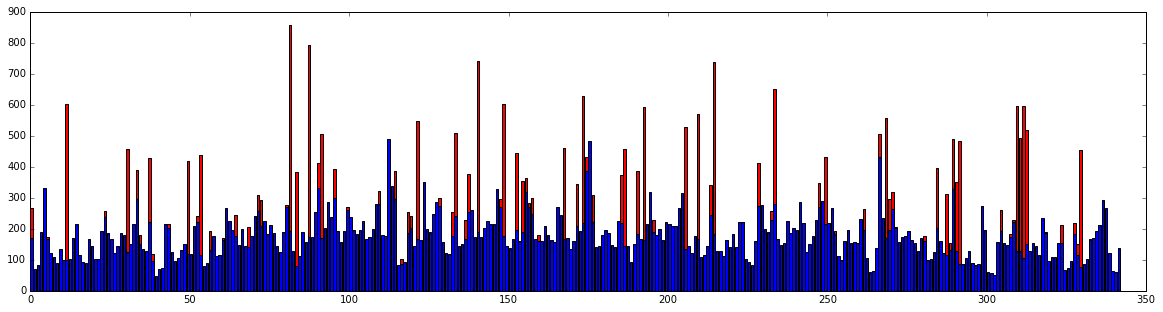

2004-05-26
0.470760233918


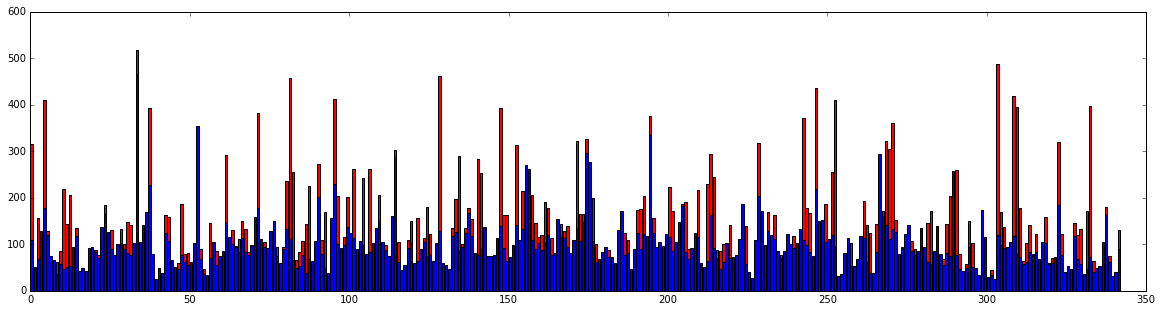

2004-04-22
0.672514619883


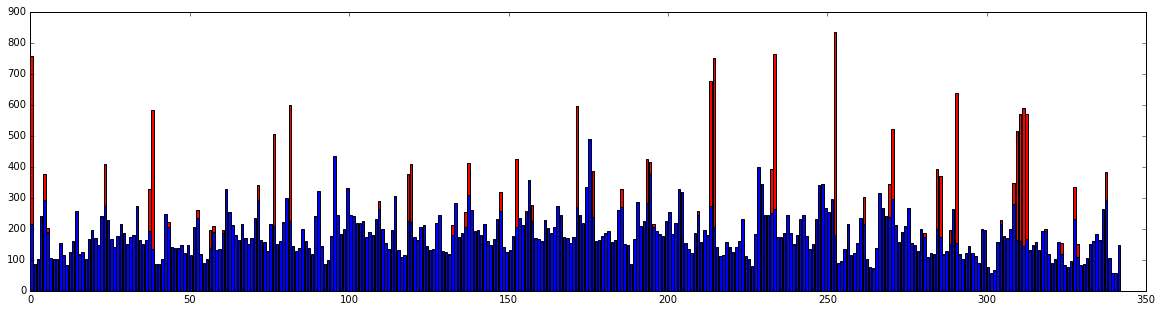

2004-06-13
0.836257309942


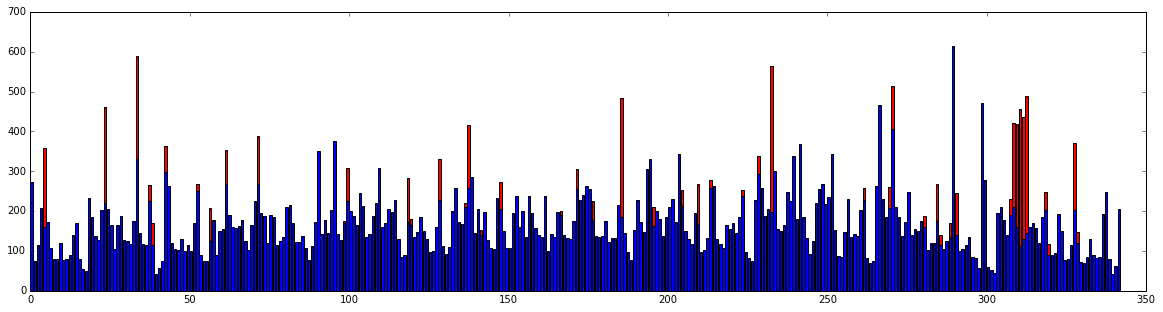

2004-07-18
0.687134502924


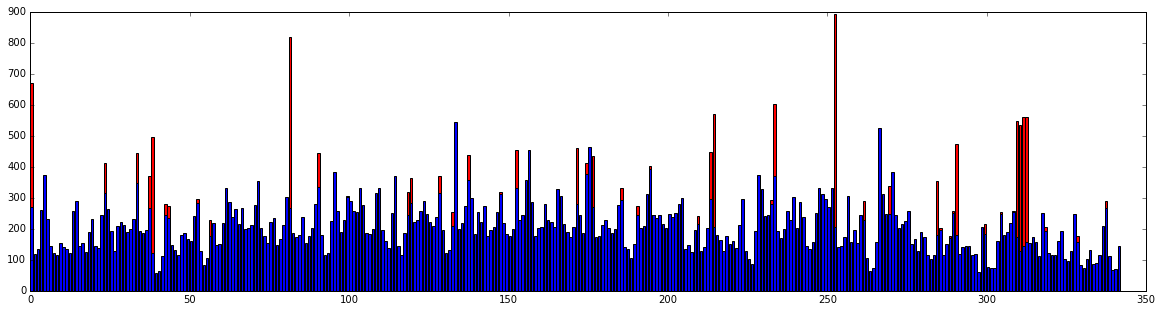

2004-04-28
0.868421052632


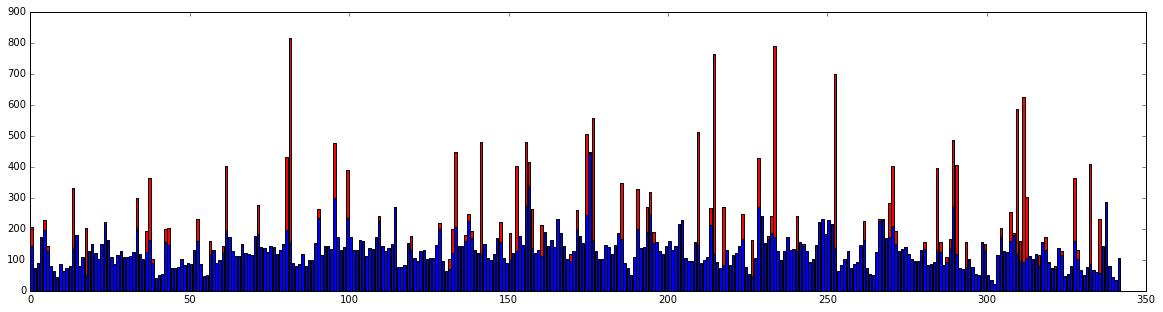

2004-05-13
0.783625730994


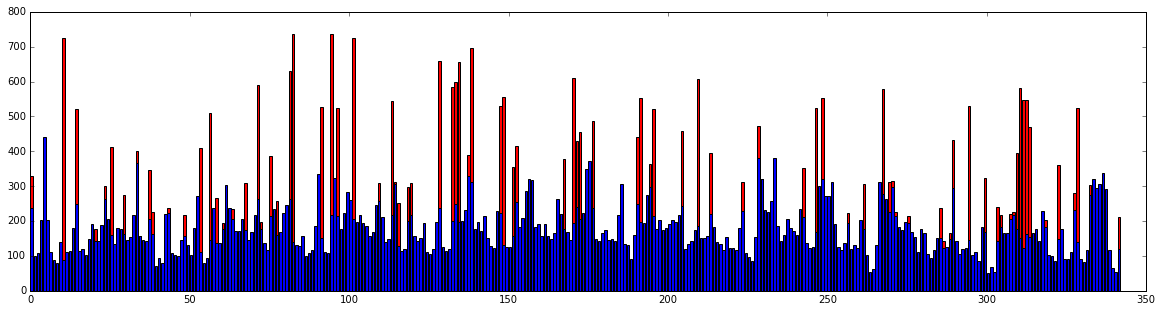

2004-06-09
0.744117647059


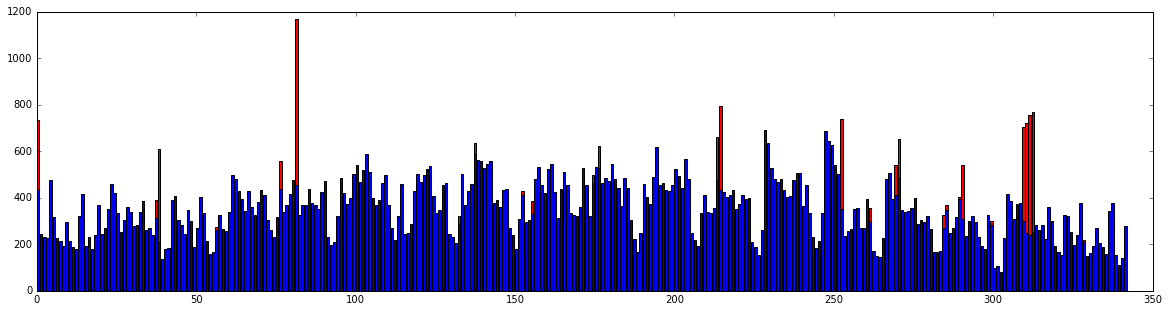

2004-03-17
0.719298245614


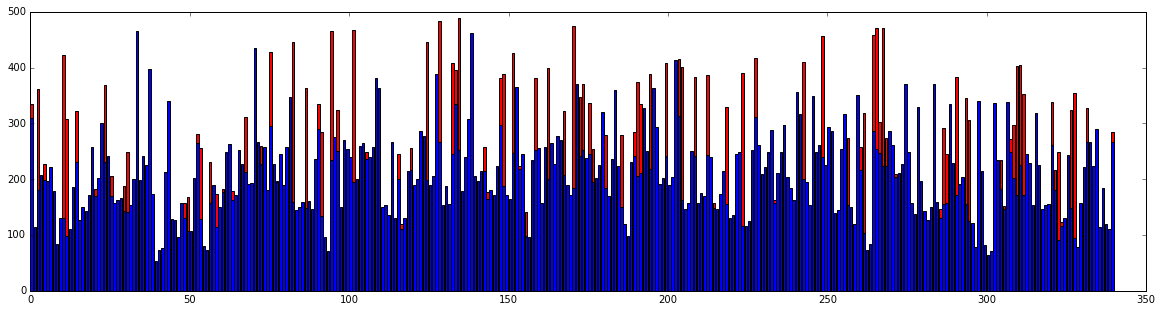

2004-06-26
0.695906432749


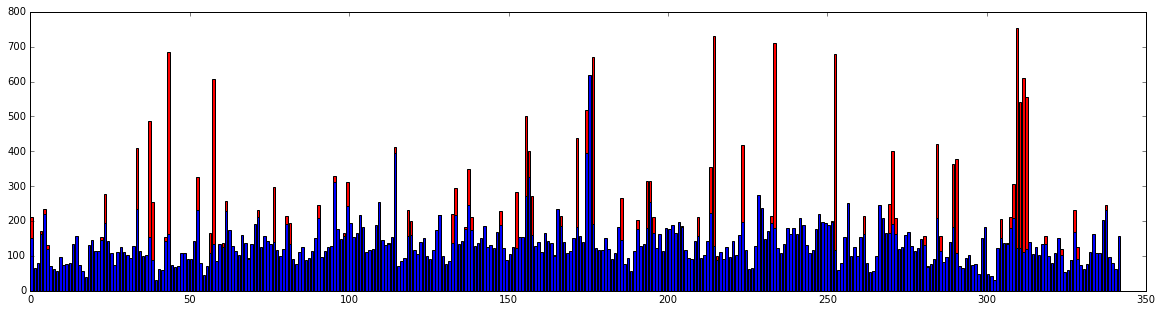

2004-07-07
0.660766961652


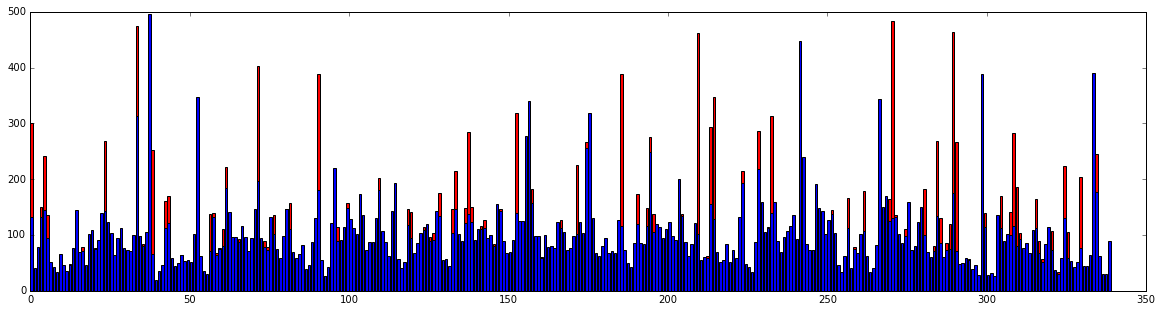

2004-03-30
0.80701754386


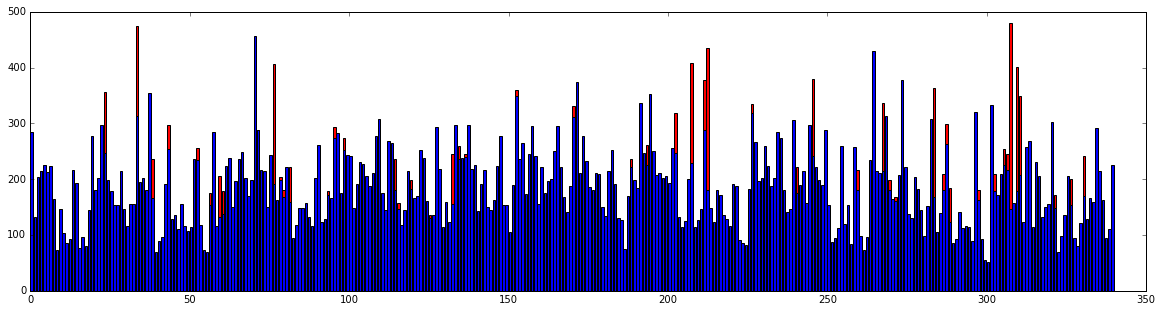

2004-06-22
0.763157894737


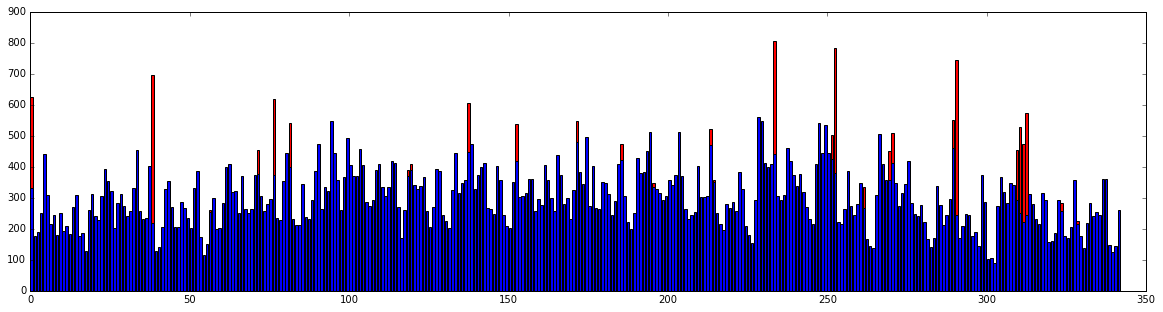

2004-06-19
0.792397660819


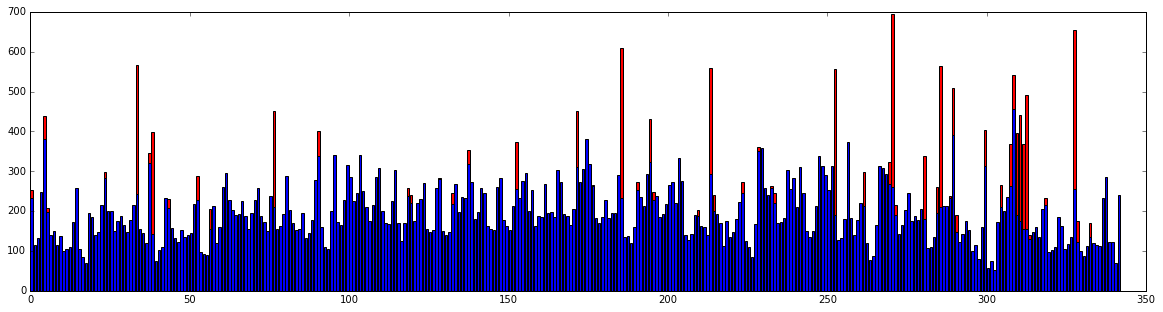

2004-07-11
0.798245614035


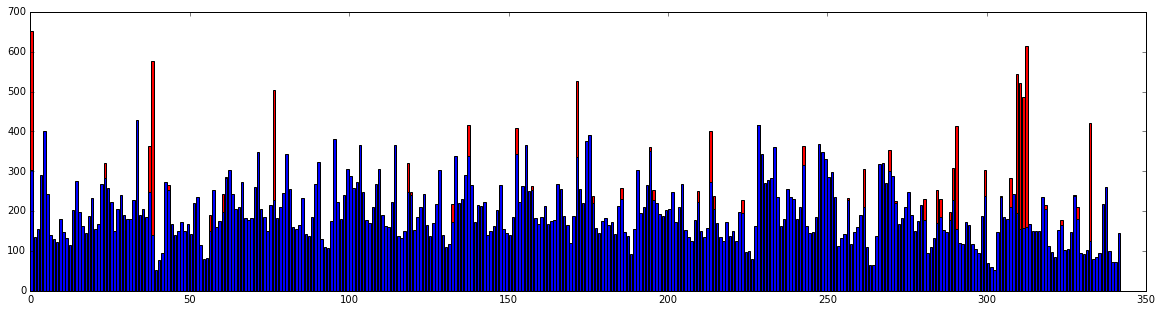

2004-07-12
0.780701754386


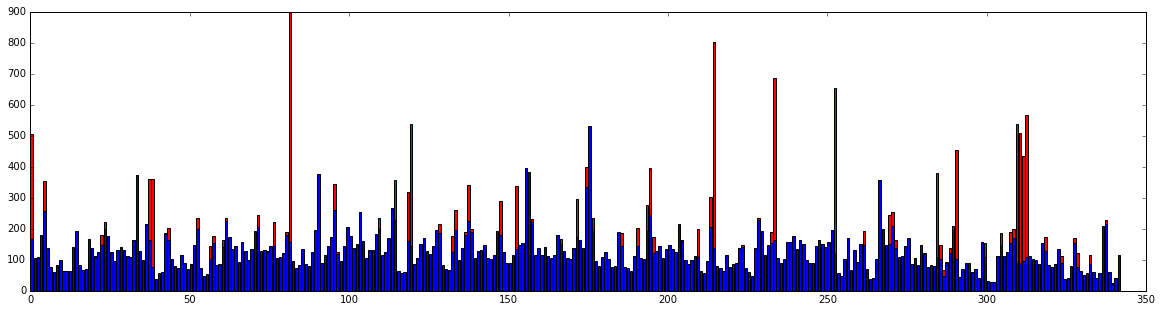

In [265]:
for date, pair in zip(days_comparison_corrected.keys(), goods_corrected):

    print date
    print float(pair[-1]-pair[0])/float(pair[-1])
    plt.figure(figsize=(20,5))
    clist=days_comparison[date][-1]
    tlist=days_comparison[date][0]
    plt.bar(range(len(tlist)),tlist, color="red")
    plt.bar(range(len(clist)),clist , color="blue")
    
    plt.show()

In [266]:
len(patches)
len(tlist)

342

In [226]:
for date, pair in zip(days_comparison_corrected.keys(), goods_corrected):
    clist=days_comparison[date][-1]
    tlist=days_comparison[date][0]
    

2004-03-19
0.74043715847


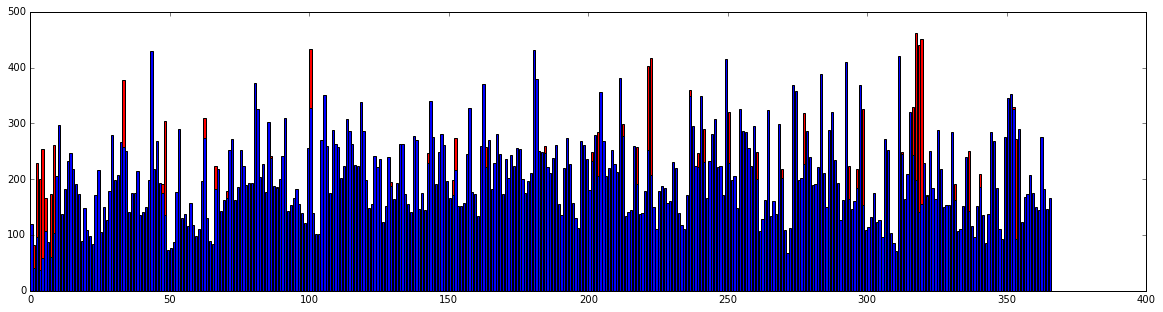

2004-04-26
0.747282608696


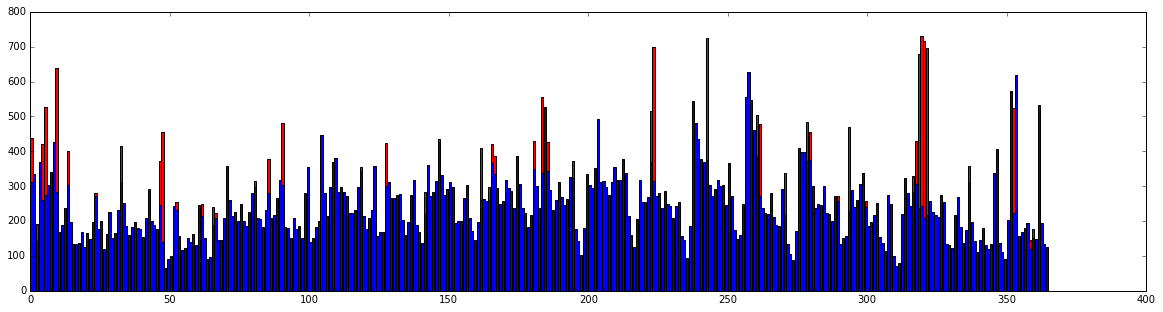

2004-05-24
0.821917808219


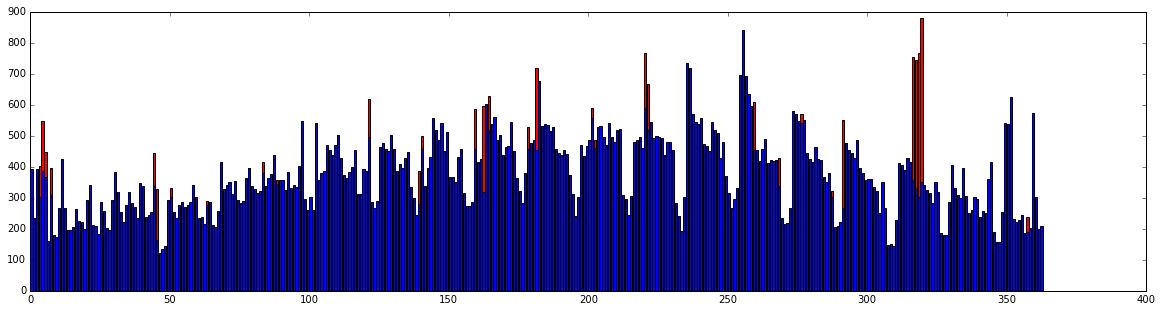

2004-05-09
0.764227642276


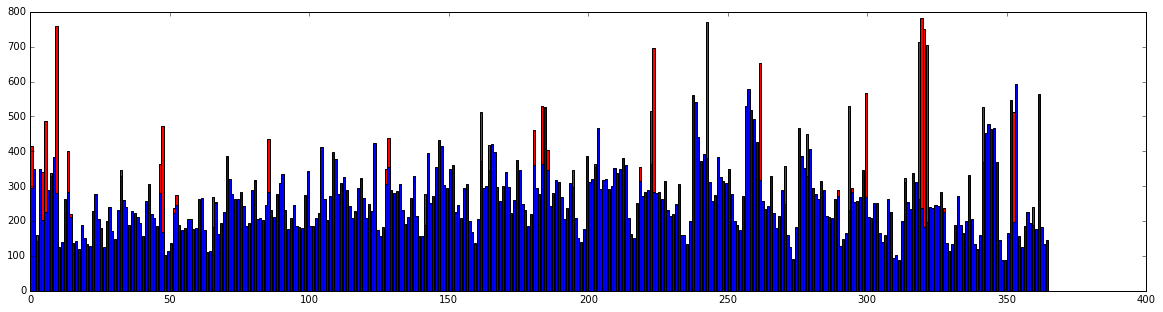

2004-04-14
0.841095890411


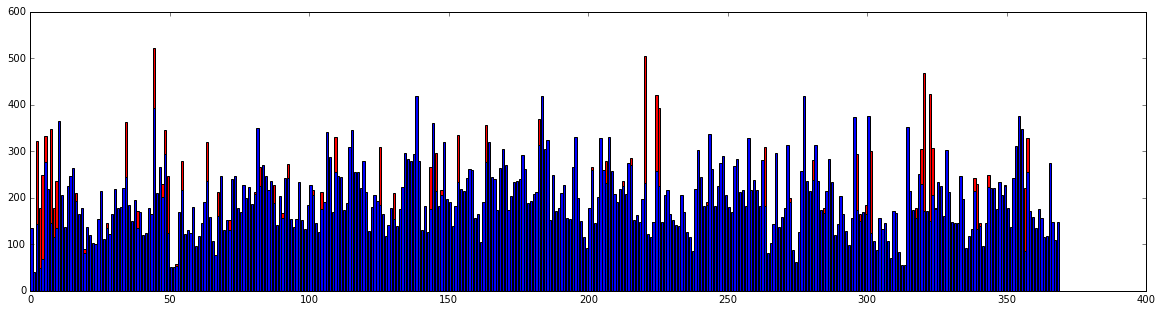

2004-05-21
0.734417344173


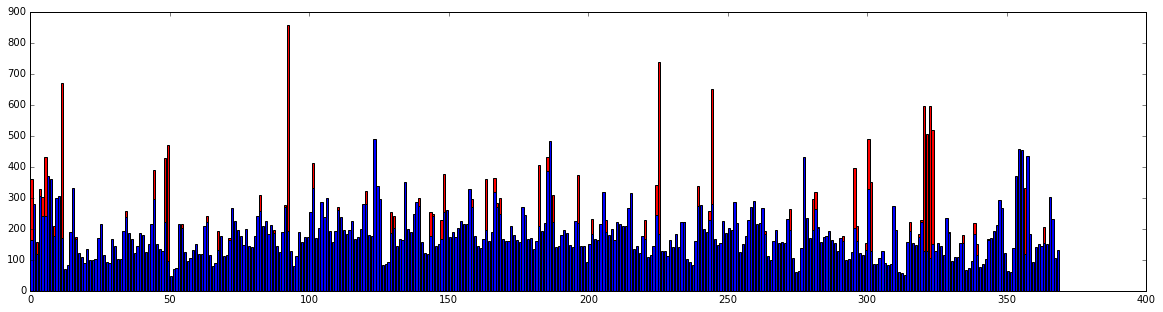

2004-05-26
0.715447154472


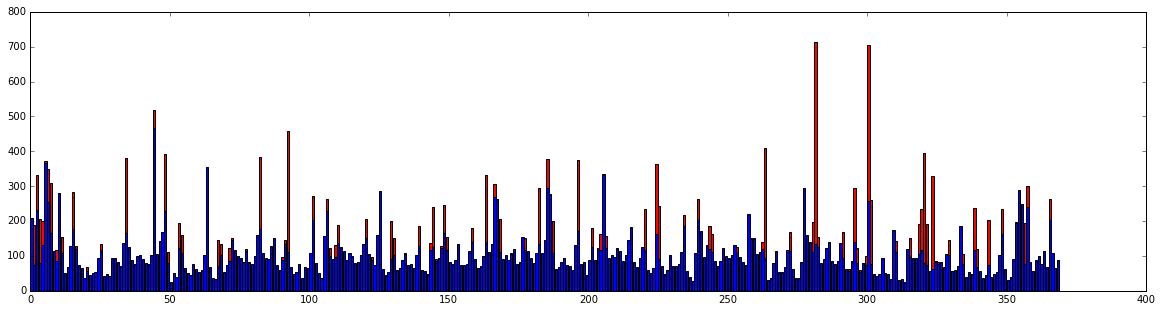

2004-04-22
0.74043715847


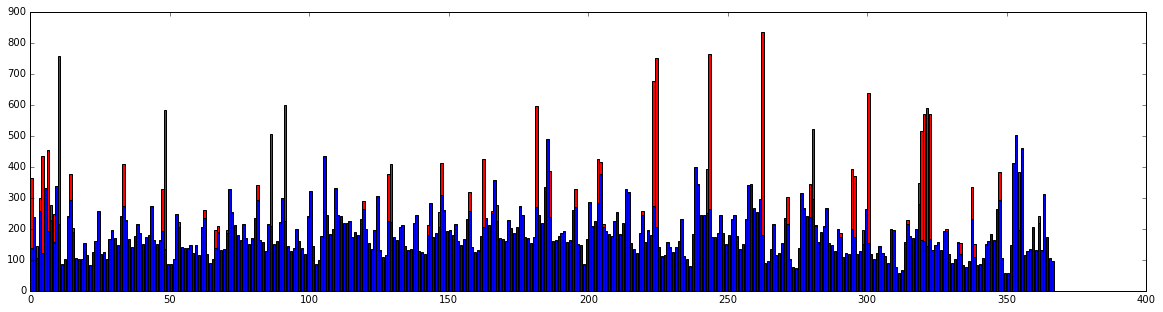

2004-06-13
0.876033057851


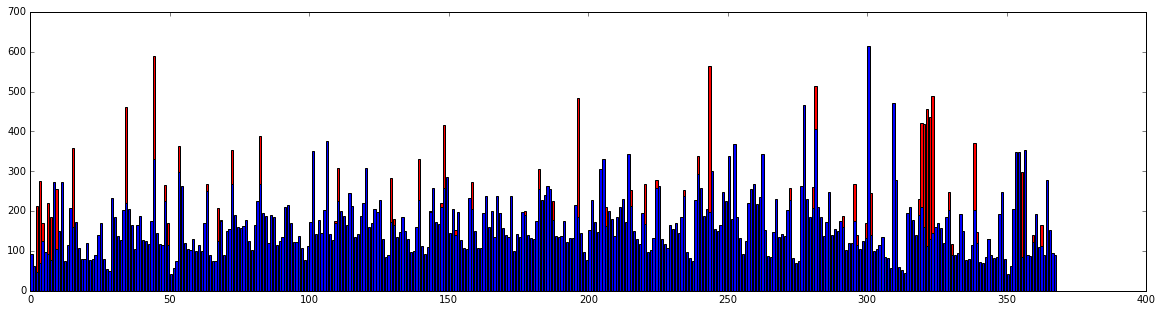

2004-07-18
0.730458221024


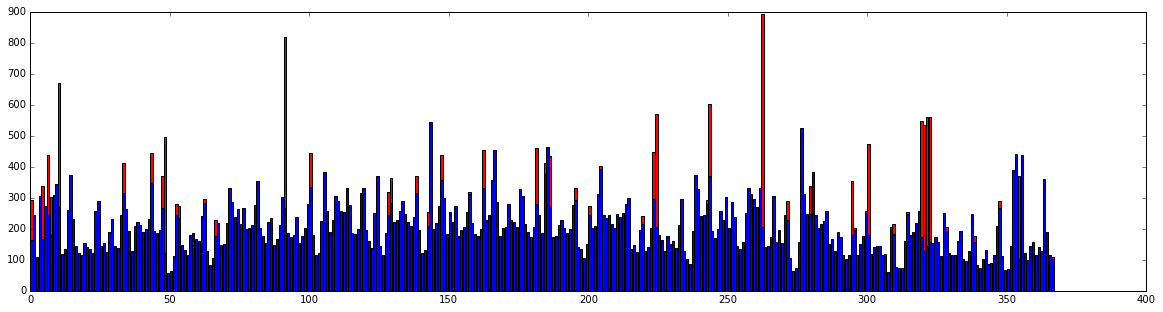

2004-04-28
0.860273972603


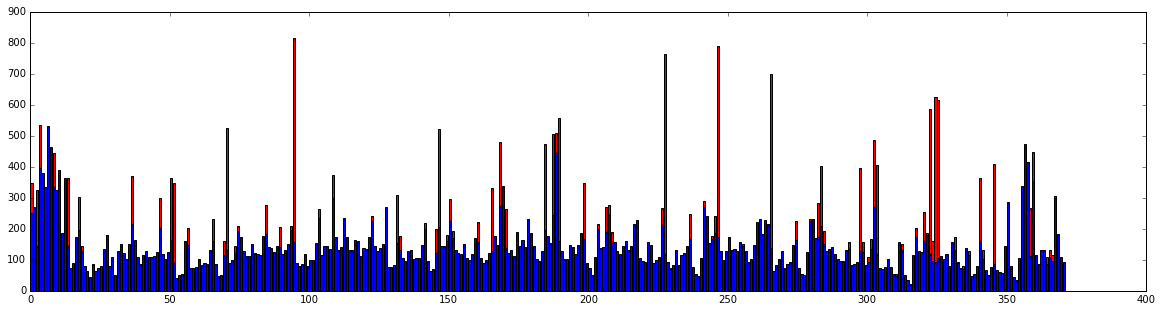

2004-05-13
0.776566757493


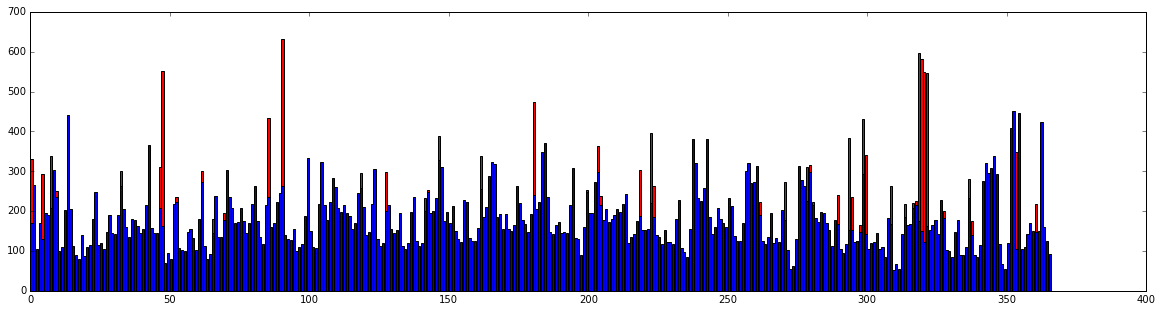

2004-06-09
0.73097826087


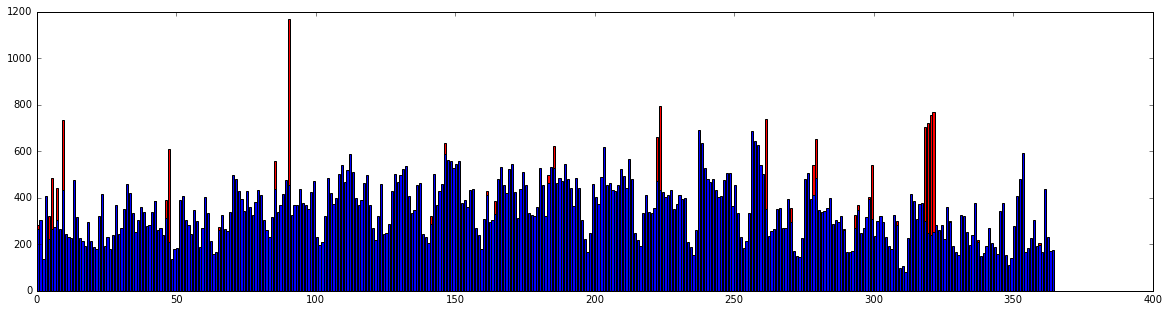

2004-03-17
0.717391304348


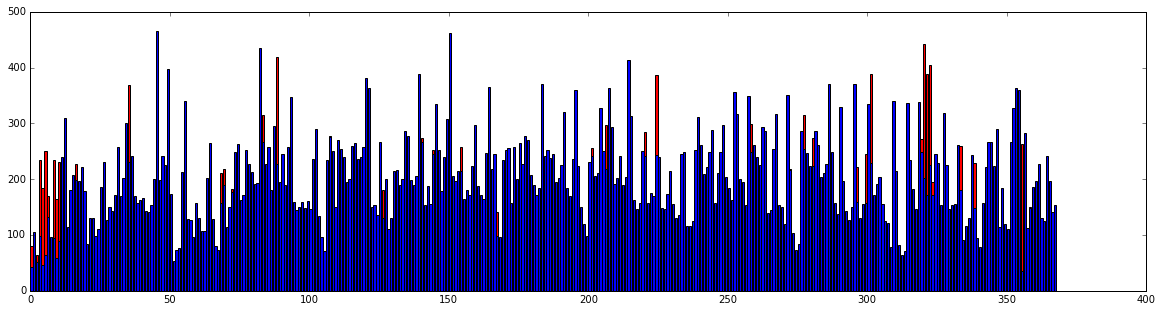

2004-06-26
0.685636856369


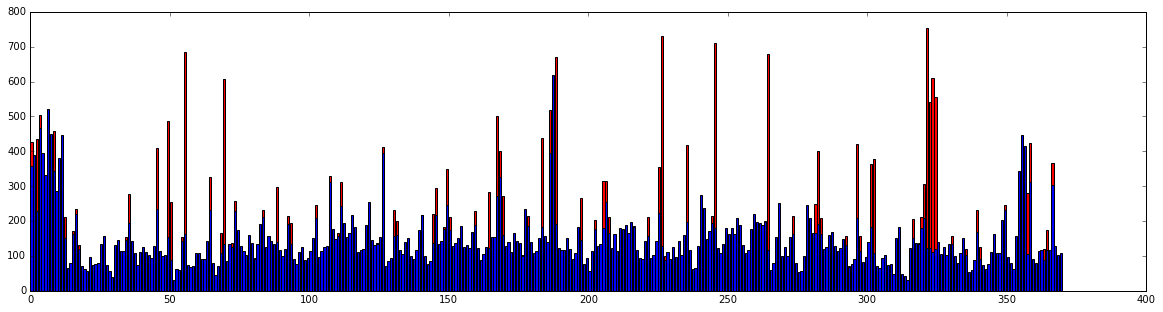

2004-07-07
0.653950953678


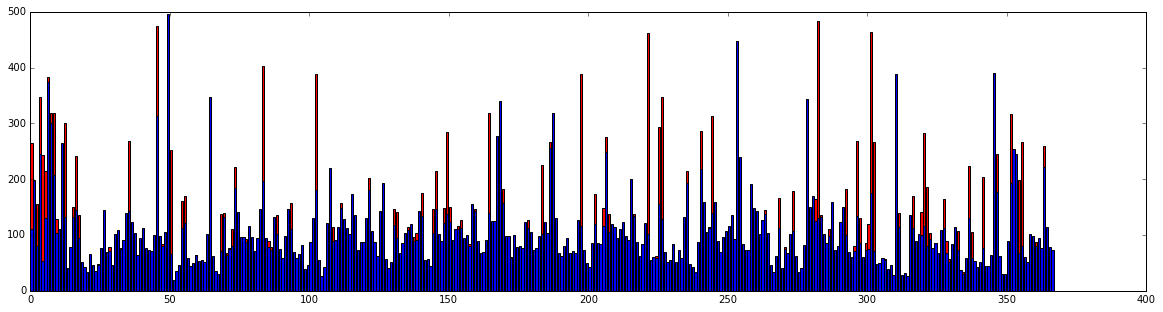

2004-03-30
0.800546448087


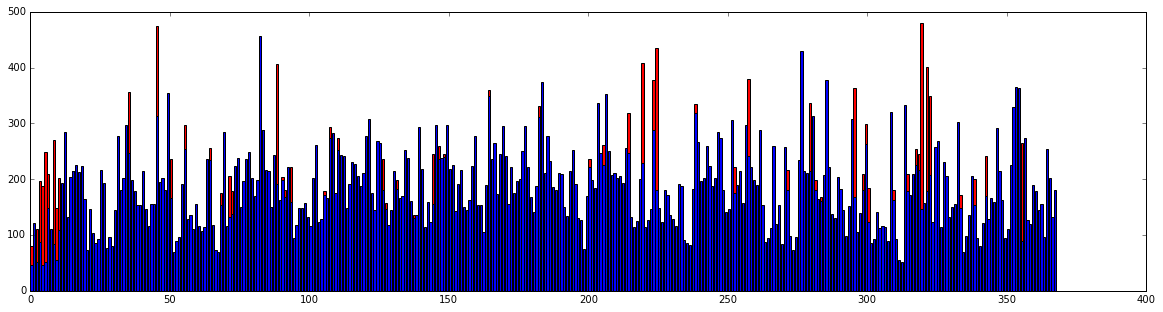

2004-06-22
0.751351351351


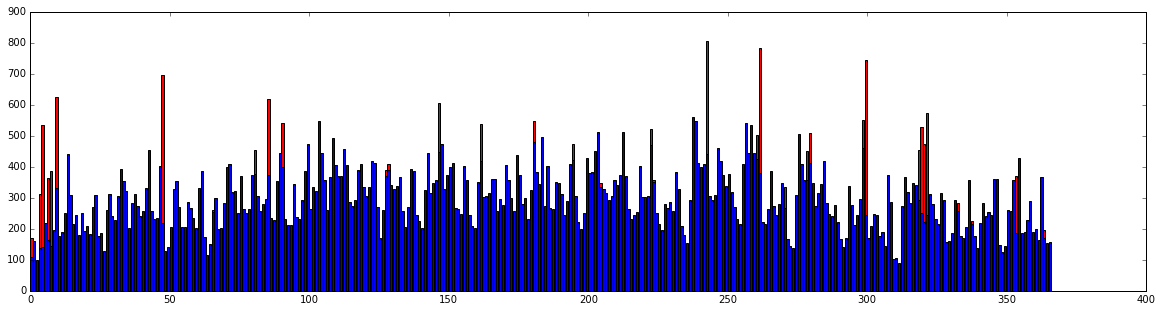

2004-06-19
0.79347826087


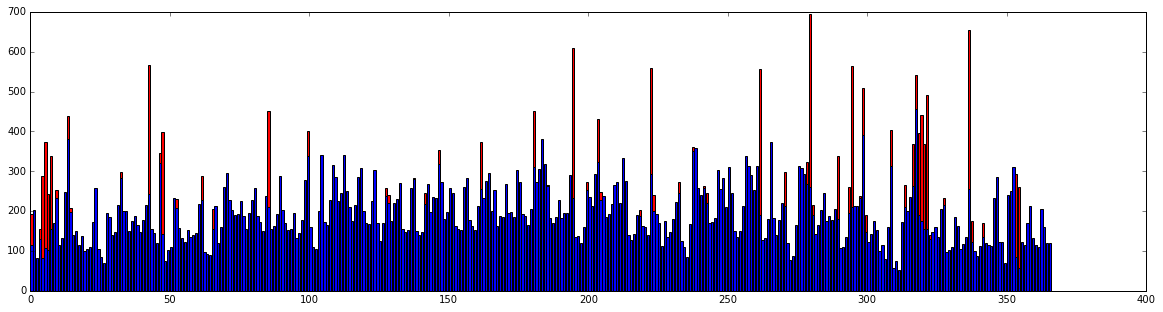

2004-07-11
0.784741144414


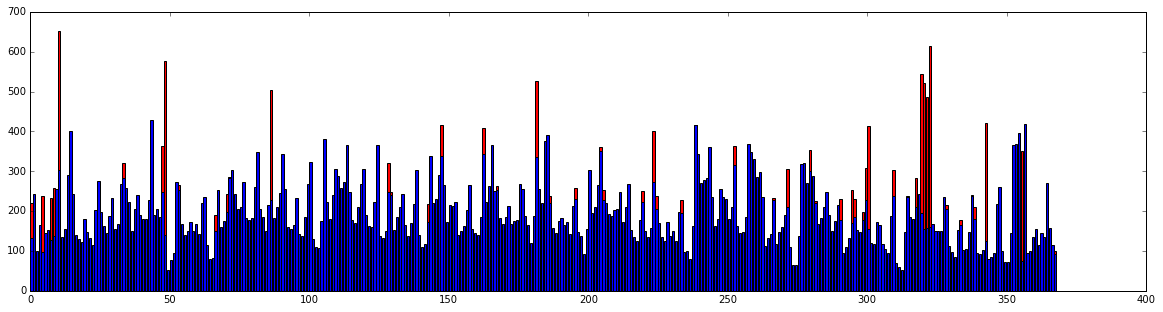

2004-07-12
0.775956284153


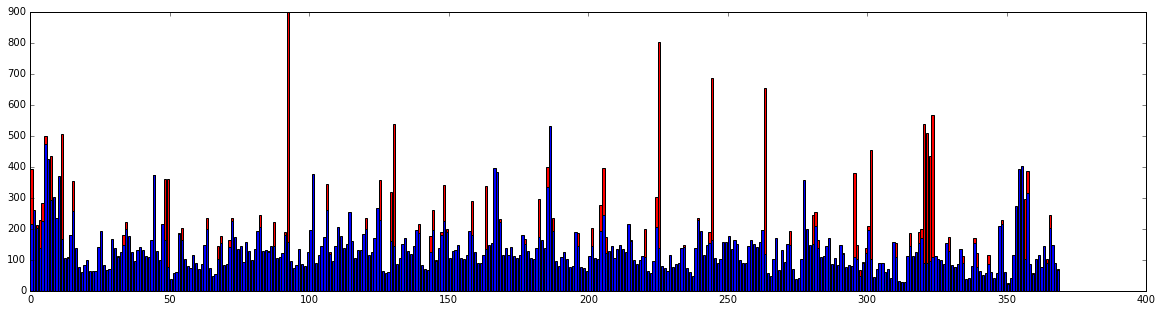

In [225]:
for date, pair in zip(days_comparison_corrected.keys(), goods_corrected):

    print date
    print float(pair[-1]-pair[0])/float(pair[-1])
    plt.figure(figsize=(20,5))
    clist=days_comparison[date][-1]
    tlist=days_comparison[date][0]
    plt.bar(range(len(tlist)),tlist, color="red")
    plt.bar(range(len(clist)),clist , color="blue")
    
    plt.show()

2004-03-19
0.86301369863


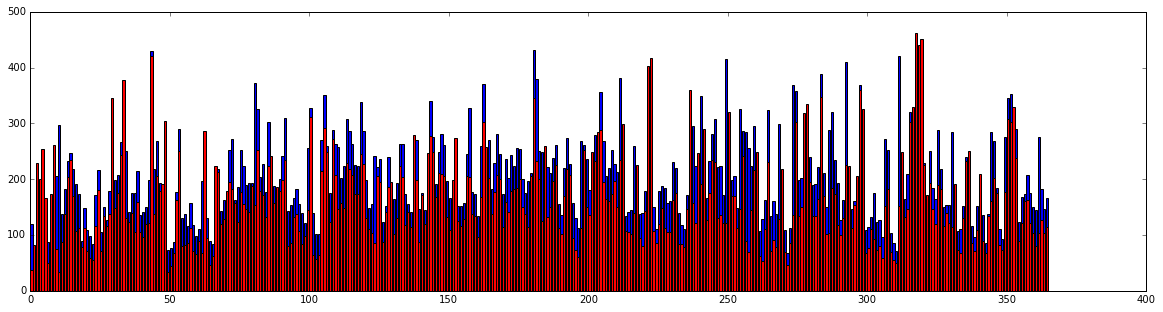

2004-04-26
0.882513661202


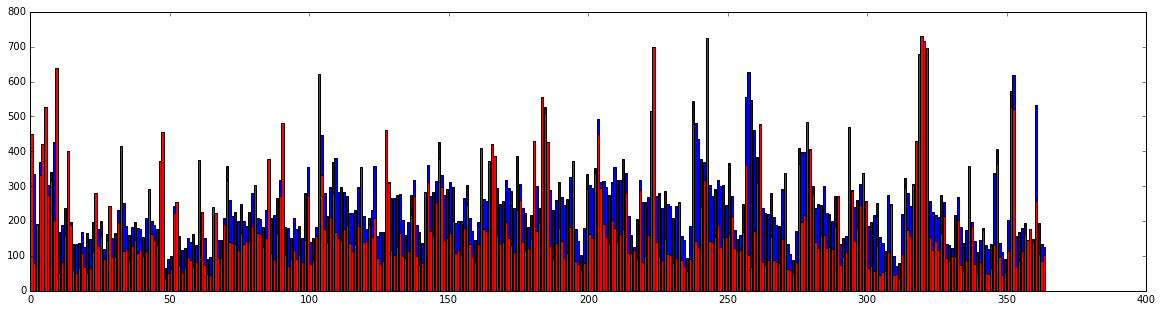

2004-05-24
0.85989010989


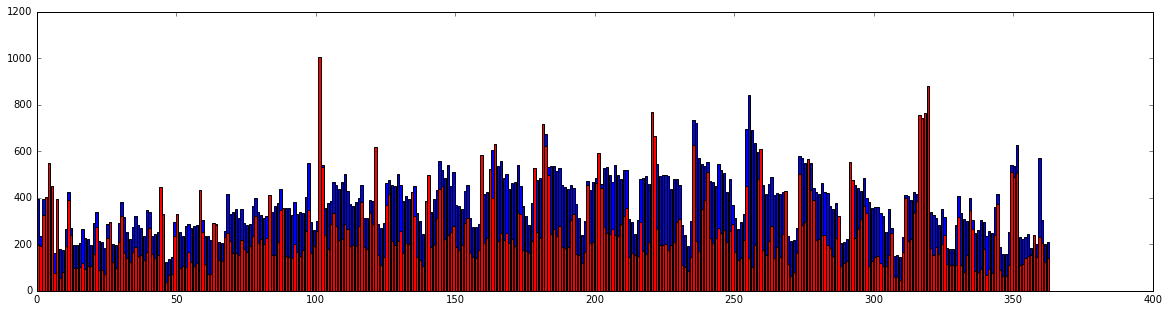

2004-05-09
0.817438692098


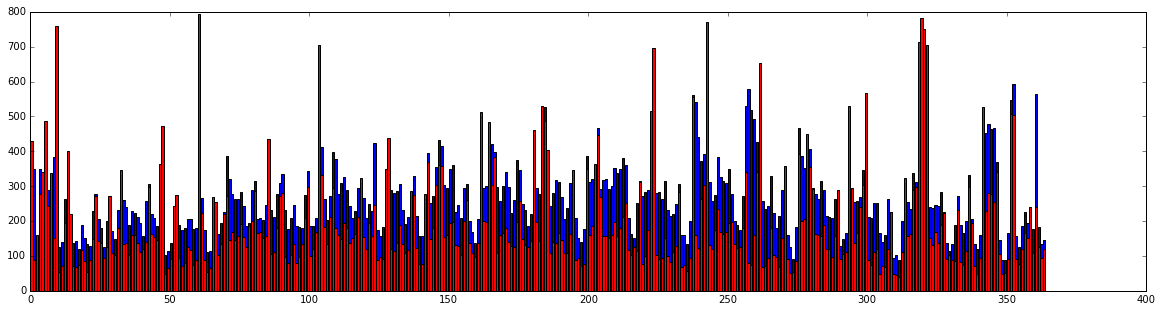

2004-04-14
0.868131868132


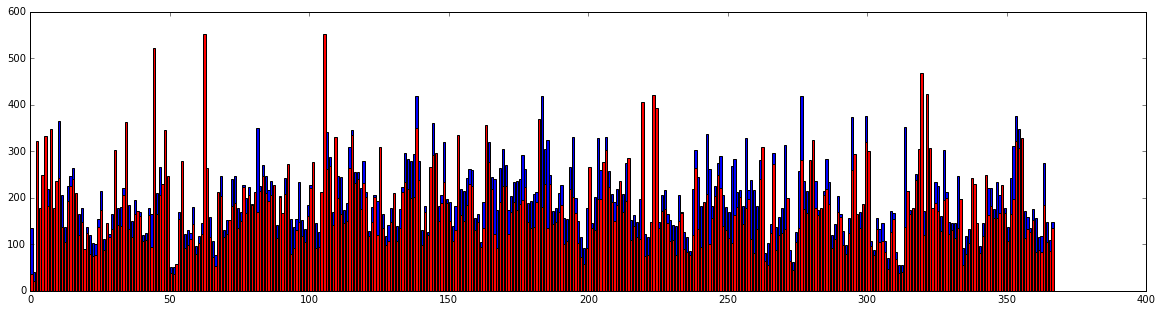

2004-05-21
0.804347826087


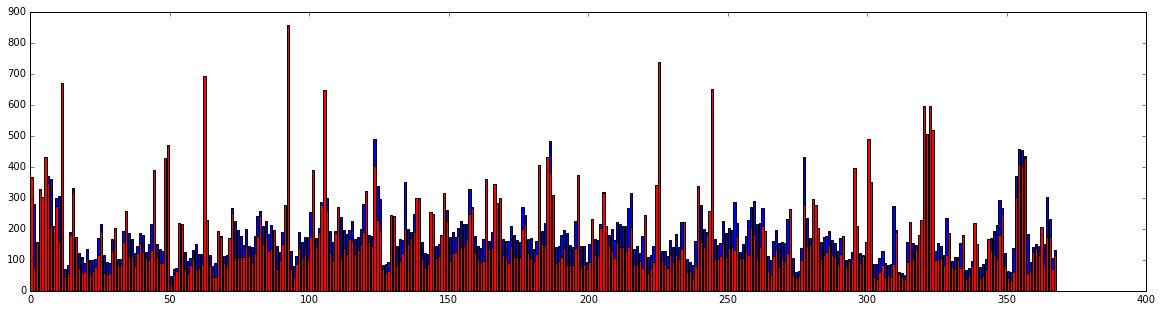

2004-05-26
0.70652173913


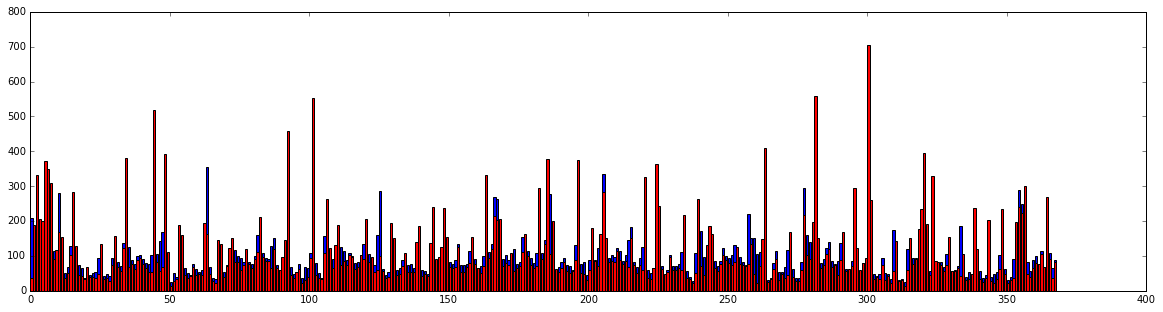

2004-04-22
0.860273972603


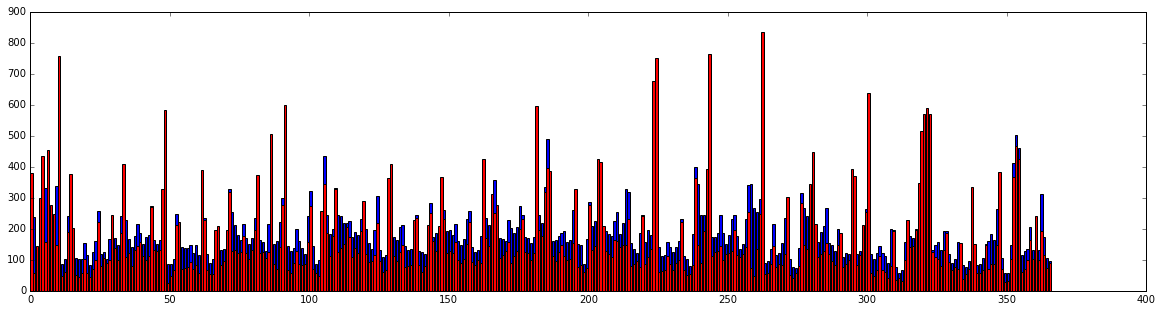

2004-06-13
0.906336088154


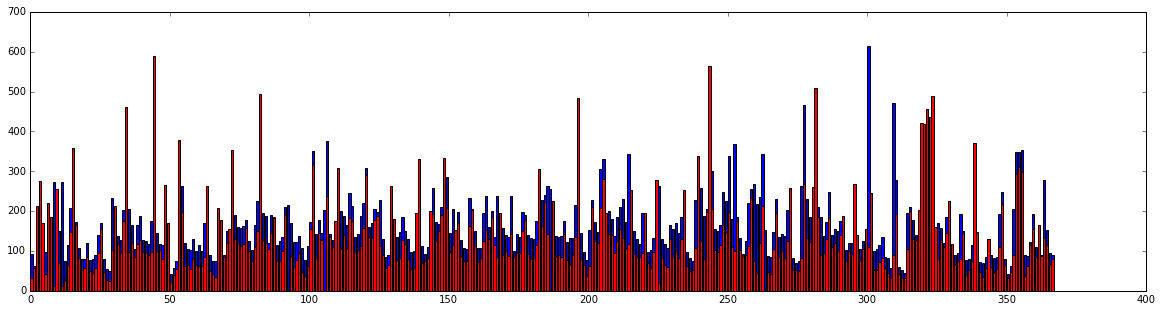

2004-07-18
0.748648648649


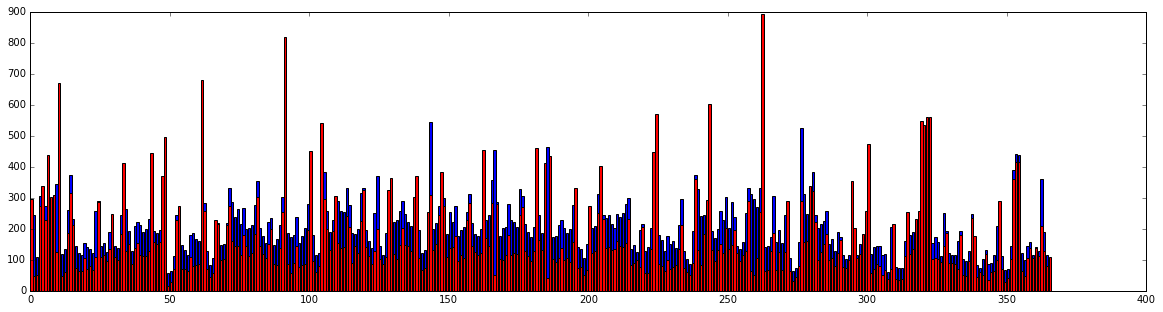

2004-04-28
0.904109589041


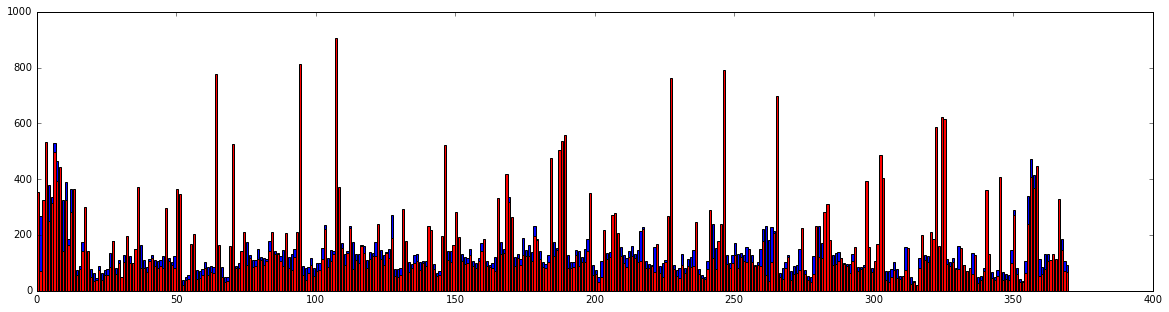

2004-05-13
0.825136612022


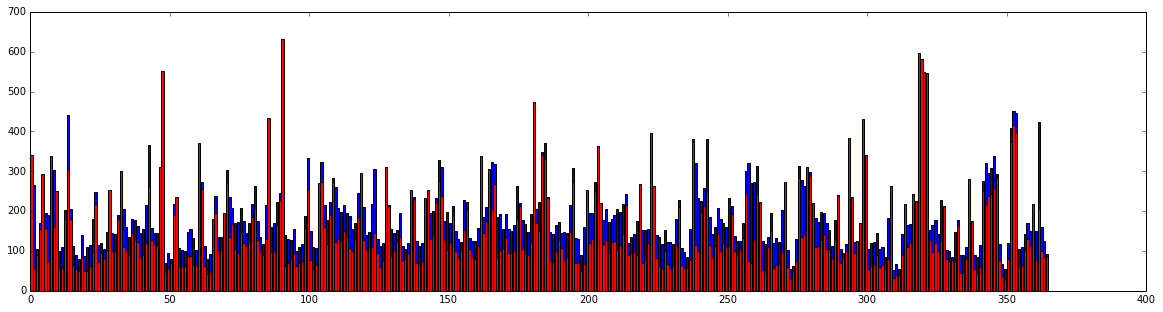

2004-06-09
0.825613079019


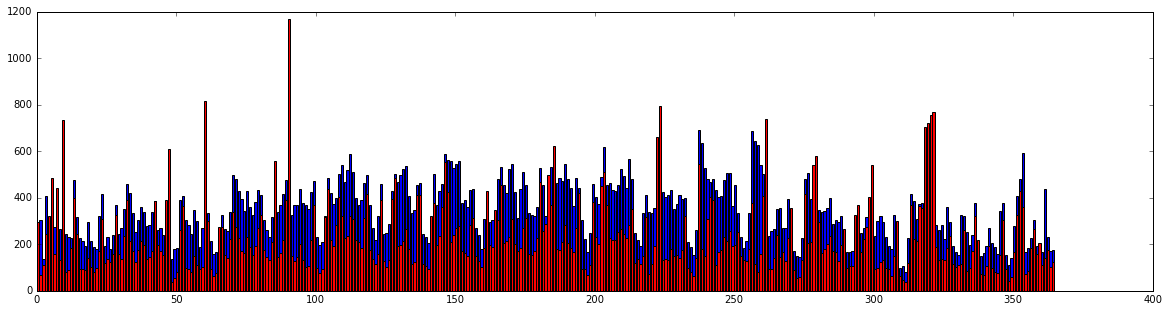

2004-03-17
0.844686648501


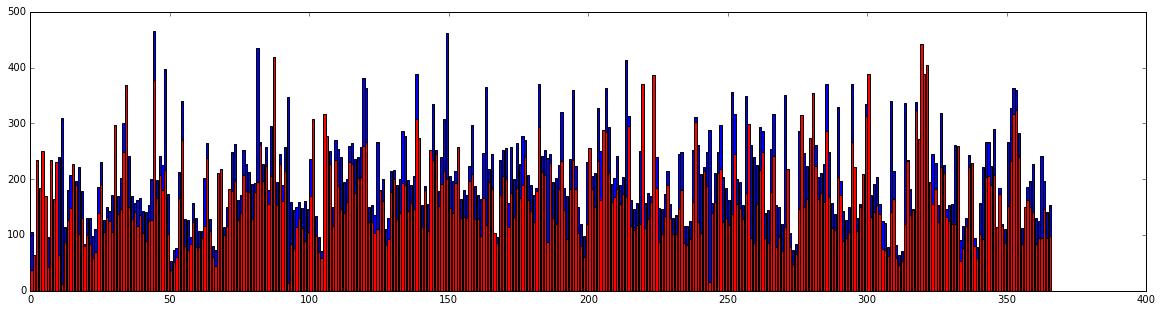

2004-06-26
0.736413043478


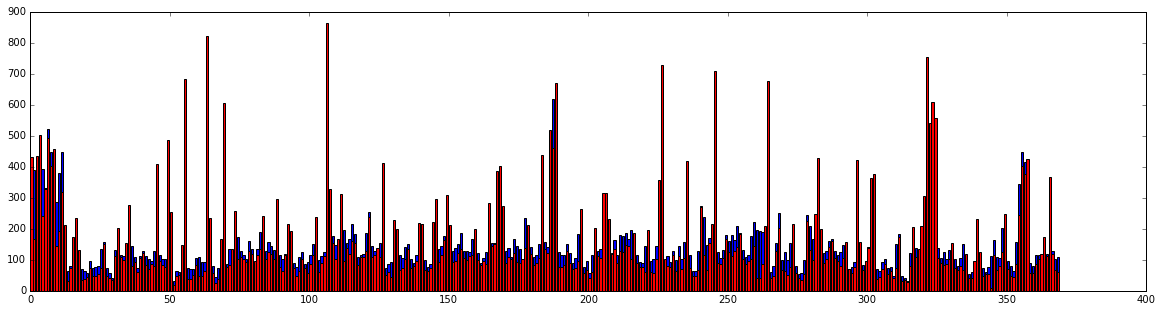

2004-07-07
0.699453551913


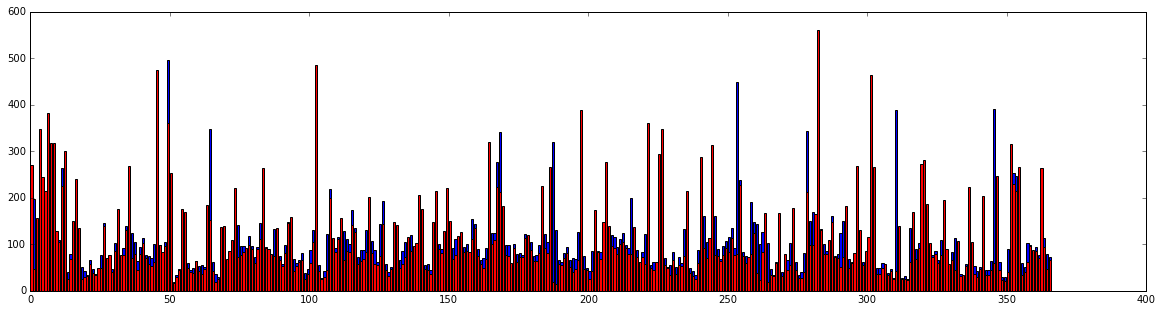

2004-03-30
0.909589041096


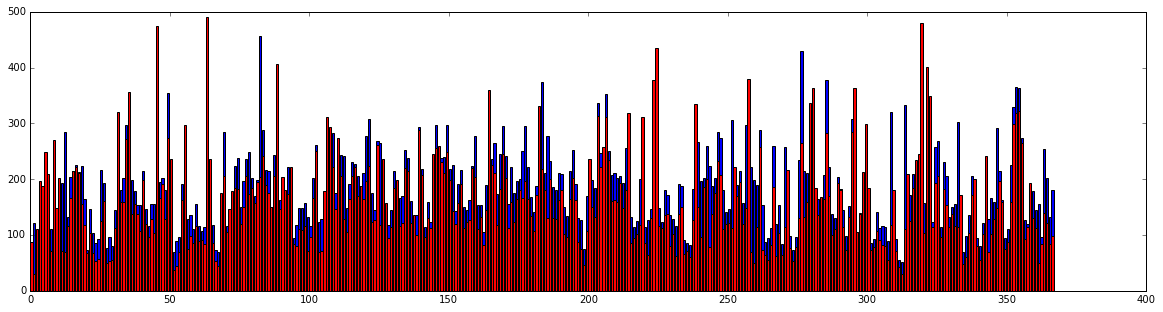

2004-06-22
0.745257452575


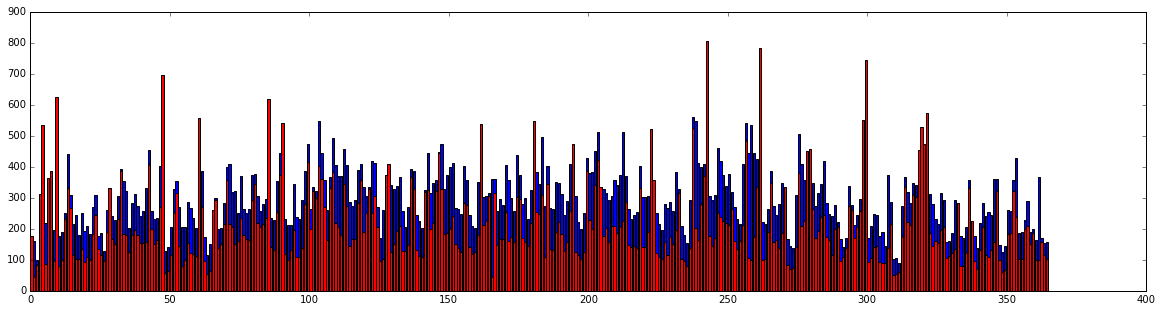

2004-06-19
0.852861035422


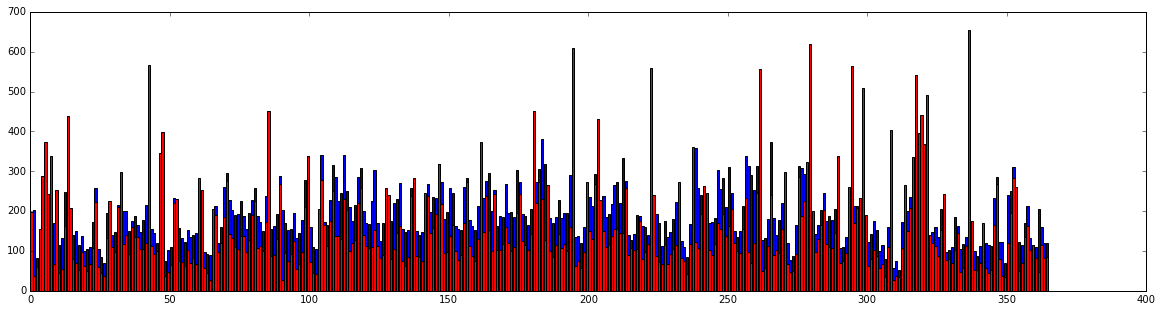

2004-07-11
0.852459016393


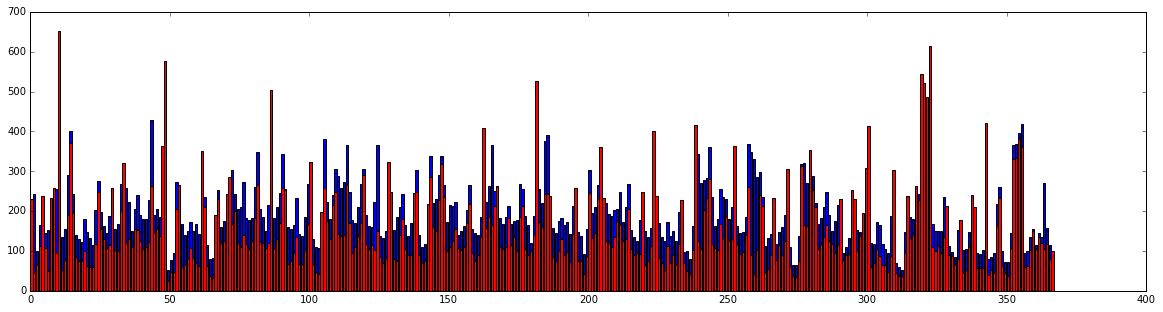

2004-07-12
0.830136986301


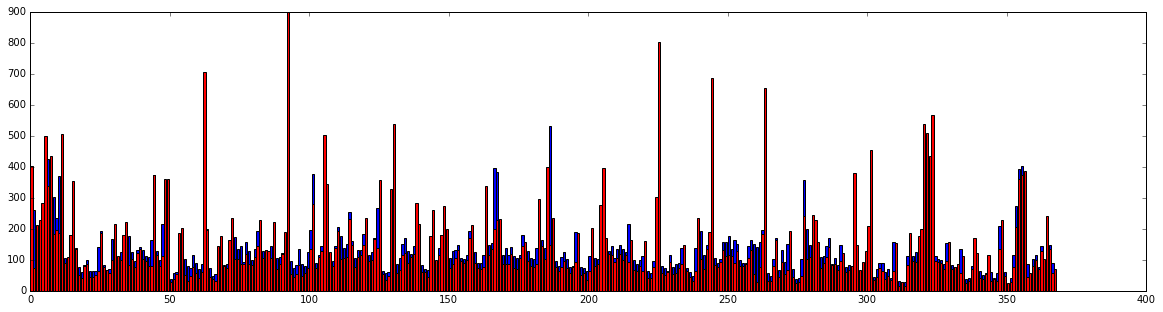

In [176]:

for date, pair in zip(days_comparison.keys(), goods):

    print date
    print float(pair[-1]-pair[0])/float(pair[-1])
    plt.figure(figsize=(20,5))
    clist=days_comparison[date][-1]
    tlist=days_comparison[date][0]
    plt.bar(range(len(clist)),clist , color="blue")
    plt.bar(range(len(tlist)),tlist, color="red")
    plt.show()

In [159]:
days_comparison["2004-05-09"][0]

[429,
 89,
 160,
 277,
 342,
 487,
 243,
 338,
 152,
 760,
 53,
 72,
 193,
 401,
 219,
 72,
 67,
 73,
 118,
 85,
 55,
 87,
 149,
 272,
 144,
 136,
 94,
 125,
 273,
 109,
 103,
 181,
 347,
 134,
 138,
 104,
 160,
 160,
 137,
 112,
 120,
 140,
 299,
 163,
 155,
 146,
 363,
 473,
 49,
 66,
 91,
 244,
 275,
 93,
 70,
 79,
 126,
 116,
 75,
 87,
 795,
 222,
 88,
 53,
 64,
 269,
 256,
 103,
 134,
 220,
 272,
 146,
 170,
 145,
 158,
 191,
 154,
 127,
 187,
 200,
 286,
 167,
 168,
 152,
 156,
 434,
 106,
 111,
 179,
 273,
 280,
 97,
 80,
 104,
 135,
 81,
 96,
 133,
 209,
 297,
 100,
 120,
 168,
 705,
 332,
 182,
 133,
 212,
 295,
 180,
 160,
 149,
 195,
 179,
 137,
 151,
 164,
 213,
 324,
 153,
 121,
 194,
 158,
 246,
 88,
 97,
 90,
 348,
 438,
 120,
 113,
 136,
 188,
 133,
 109,
 118,
 287,
 276,
 124,
 76,
 76,
 277,
 368,
 149,
 179,
 302,
 361,
 359,
 154,
 161,
 194,
 198,
 132,
 129,
 103,
 201,
 261,
 137,
 108,
 97,
 136,
 512,
 200,
 198,
 485,
 302,
 384,
 107,
 161,
 167,
 181,
 139,